In [1]:
import os
import SimpleITK as sitk
# ! pip install SimpleITK==1.2.4
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from ipywidgets import interact, fixed
from IPython.display import display
import scipy
import scipy.linalg
import numpy as np
from tqdm.notebook import tqdm
# import nibabel as nib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Helper functions (display / intensity) + DF

In [2]:
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    


def interactive_view(img):
    size = img.GetSize()
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)))
    
    
def label_overlay(img, seg):
    minmax = sitk.MinimumMaximumImageFilter()
    minmax.Execute(img)
    low, high = minmax.GetMinimum(), minmax.GetMaximum()
    img_norm = (img - low) / (high - low)
    img_uint8 = sitk.Cast(256 * img_norm, sitk.sitkUInt8)
    return sitk.LabelOverlay(img_uint8, seg)

def display_overlay(img, seg, *args, **kwargs):
    display_image(label_overlay(img, seg), *args, **kwargs)

In [203]:
# DATAFRAME HELPER
def _get_coords(single_test, start_x=0, start_y=0,start_z=0, start_loc=-1):
    # gets coords of ENDBPID
    x_diff= (single_test.centerlinelength*single_test.dircosx).values
    y_diff = (single_test.centerlinelength*single_test.dircosy).values
    z_diff = (single_test.centerlinelength*single_test.dircosz).values
    endbpid = single_test.endbpid.values
    startbpid = single_test.startbpid.values
    x = np.zeros_like(x_diff)
    y = np.zeros_like(x_diff)
    z = np.zeros_like(x_diff)
    for i in range(len(x_diff)):
        if startbpid[i] == start_loc:
            print("adding start loc")
            x[i] = x_diff[i] + start_x
            y[i] = y_diff[i] + start_y
            z[i] = z_diff[i] + start_z
        else:
            # find parent id
            parent = np.where(endbpid == startbpid[i])
            print("parent", parent)
            x[i] = x_diff[i] + x[parent] 
            y[i] = y_diff[i] + y[parent] 
            z[i] = z_diff[i] + z[parent] 
    # put into dataframe
    coords_df = pd.DataFrame({"x": x, "y": y, "z":z})
    
    return single_test.join(coords_df, how="left")



adding start loc
adding start loc
parent (array([1]),)
parent (array([1]),)
parent (array([0]),)
parent (array([0]),)
parent (array([2]),)
parent (array([2]),)
parent (array([3]),)
parent (array([3]),)
parent (array([4]),)
parent (array([4]),)
parent (array([5]),)
parent (array([5]),)
parent (array([7]),)
parent (array([7]),)
parent (array([6]),)
parent (array([6]),)
parent (array([8]),)
parent (array([8]),)
parent (array([9]),)
parent (array([9]),)
parent (array([11]),)
parent (array([11]),)
parent (array([10]),)
parent (array([10]),)
parent (array([12]),)
parent (array([12]),)
parent (array([13]),)
parent (array([13]),)
parent (array([14]),)
parent (array([14]),)
parent (array([15]),)
parent (array([15]),)
parent (array([17]),)
parent (array([17]),)
parent (array([16]),)
parent (array([16]),)
parent (array([18]),)
parent (array([18]),)
parent (array([19]),)
parent (array([19]),)
parent (array([20]),)
parent (array([20]),)
parent (array([21]),)
parent (array([21]),)
parent (array([22]

### Test data

In [4]:
aw_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/AW/3010007_AW.nii.gz"
img_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/IMG/3010007_IMG.nii.gz"
lung_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/LUNG/3010007_LUNG.nii.gz"

In [5]:
aw_img = sitk.ReadImage(aw_test)
lung_img = sitk.ReadImage(lung_test)
img = sitk.ReadImage(img_test)

In [208]:
# get the tree data for this participant
df = pd.read_csv(os.path.abspath("/home/sneha/airway_exploration/e5_cleaned_v1.csv"))
tree = df.loc[df.idno == 3010007]
if 'radius' not in tree.columns:
    tree['radius'] = np.sqrt(tree.avginnerarea.copy()/np.pi)
    tree['radius'].fillna(0, inplace=True)
    tree['radius'] = tree.radius.astype(int)
display(tree)

startx=220
starty=260
startz=223
start_loc= 1 #(carina)
# 260,220,223
tree_w_coords = _get_coords(tree.loc[tree.startbpid != -1], start_x=startx, start_y=starty, start_z=startz, start_loc=start_loc)
tree_w_coords.dropna(inplace=True)
tree_w_coords[['x', 'y', 'z']] = tree_w_coords[['x', 'y', 'z']].astype(int)


def get_parent_coords(x, col='x'):
        v = np.array(tree_w_coords['endbpid'].to_list()) # exclude trachea for the participant
        if np.any(np.isin(v,x.startbpid)):
            index = np.argmax(np.isin(v,x.startbpid)) # find row that contains the parent branch (prev bpid)
#             print("index",x.startbpid, index)
            try:
                row_parent = tree_w_coords.iloc[index] # adding 1 back on for the trachea
            except:
                print("Help", index, len(x))
            return row_parent[col]
        else:
            print("No parent")
            return np.nan
        
tree_w_coords["parent_loc_x"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'x'), axis=1)
tree_w_coords["parent_loc_y"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'y'), axis=1)
tree_w_coords["parent_loc_z"]=tree_w_coords.apply(lambda x: get_parent_coords(x,'z'), axis=1)

# fill parent loc fo rtrachea with start
tree_w_coords.loc[tree_w_coords.startbpid == start_loc, 'parent_loc_x']= startx
tree_w_coords.loc[tree_w_coords.startbpid ==  start_loc,'parent_loc_y']= starty
tree_w_coords.loc[tree_w_coords.startbpid ==  start_loc, 'parent_loc_z']= startz
tree_w_coords.head()

/home/sneha/miniconda3/envs/my_env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_22667/653263952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree['radius'] = np.sqrt(tree.avginnerarea.copy()/np.pi)
/tmp/ipykernel_22667/653263952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree['radius'].fillna(0, inplace=True)
/tmp/ipykernel_22667/653263952.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius
0,3010007,Trachea,104.962000,351.51300,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,10
1,3010007,LMB,51.014200,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,6
2,3010007,RMB,25.444200,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,8
3,3010007,BronInt,29.831900,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,5
4,3010007,RUL,16.649400,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,3010007,-,1.658150,-1.00000,5.0,18.0,377.0,354.0,101.6280,0.408248,0.816497,0.408248,12,0
377,3010007,-,14.326200,8.93574,5.0,19.0,379.0,360.0,167.6940,-0.260333,0.260333,0.929760,12,1
378,3010007,-,14.695600,6.03235,5.0,19.0,378.0,360.0,153.0900,-0.267261,0.801784,0.534522,12,1
379,3010007,-,0.865964,-1.00000,2.0,9.0,380.0,370.0,180.0000,0.000000,0.707107,0.707107,12,0


adding start loc
adding start loc
parent (array([1]),)
parent (array([1]),)
parent (array([0]),)
parent (array([0]),)
parent (array([2]),)
parent (array([2]),)
parent (array([3]),)
parent (array([3]),)
parent (array([4]),)
parent (array([4]),)
parent (array([5]),)
parent (array([5]),)
parent (array([7]),)
parent (array([7]),)
parent (array([6]),)
parent (array([6]),)
parent (array([8]),)
parent (array([8]),)
parent (array([9]),)
parent (array([9]),)
parent (array([11]),)
parent (array([11]),)
parent (array([10]),)
parent (array([10]),)
parent (array([12]),)
parent (array([12]),)
parent (array([13]),)
parent (array([13]),)
parent (array([14]),)
parent (array([14]),)
parent (array([15]),)
parent (array([15]),)
parent (array([17]),)
parent (array([17]),)
parent (array([16]),)
parent (array([16]),)
parent (array([18]),)
parent (array([18]),)
parent (array([19]),)
parent (array([19]),)
parent (array([20]),)
parent (array([20]),)
parent (array([21]),)
parent (array([21]),)
parent (array([22]

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z
1,3010007,LMB,51.0142,148.6810,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,6,202,258,241,220.0,260.0,223.0
2,3010007,RMB,25.4442,215.5690,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,8,189,259,268,220.0,260.0,223.0
3,3010007,BronInt,29.8319,111.9830,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,5,188,258,231,189.0,259.0,268.0
4,3010007,RUL,16.6494,75.6966,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,4,262,264,273,189.0,259.0,268.0
5,3010007,LLB6,15.2959,83.2434,2.0,0.0,6.0,3.0,167.2630,0.737309,0.163846,0.655386,2,5,263,253,258,202.0,258.0,241.0


In [7]:
print(img)

Image (0x55c2ed6968e0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1341
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1320
  UpdateMTime: 1340
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  Spacing: [1, 1, 1]
  Origin: [-1, -1, 1]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-1 0 0
0 -1 0
0 0 1

  PointToIndexMatrix: 
-1 0 0
0 -1 0
0 0 1

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x55c2ed54a300)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
      Modified Time: 1337
      

In [8]:
print(img.GetSpacing(), img.GetSize())
# each voxel is 1mm, 1mm, 1mm size. The voxel grid is of size 512x512x670

(1.0, 1.0, 1.0) (512, 512, 670)


In [9]:
interactive_view(lung_img)
interactive_view(aw_img)
interactive_view(img)

# z = 0, x= 256, y = 256 on this image appears to be the top of the trachea
# --> can see this by scrolling down z axis from 0--> 670 on aw_img

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

### Single Slice

In [10]:
img_array =  sitk.GetArrayFromImage(aw_img)
size = img.GetSize()
spacing = img.GetSpacing()

width  = size[0] * spacing[0]
height = size[1] * spacing[1]
depth  = size[2] * spacing[2]

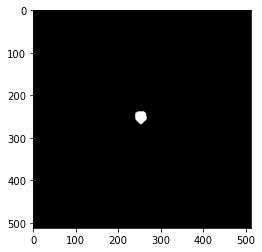

In [11]:
# top down
plt.imshow(img_array[1,:,:], cmap='gray', extent=(0, width, height, 0))

Text(0, 0.5, 'sum x,y')

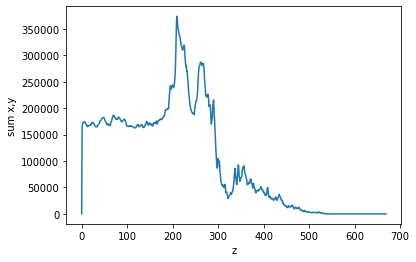

In [12]:
# sum each slice along + plot along z axis
plt.plot(np.arange(0, 670), img_array.sum(axis=(1,2)))
plt.xlabel('z')
plt.ylabel('sum x,y')

Num large circles 0
Circle (252, 249) 15


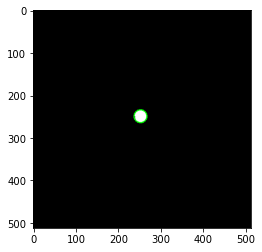

Num large circles 1
Circle (252, 247) 15


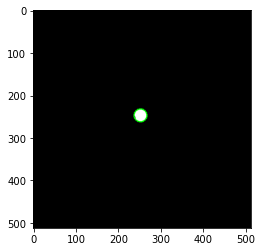

Num large circles 1
Circle (251, 245) 15


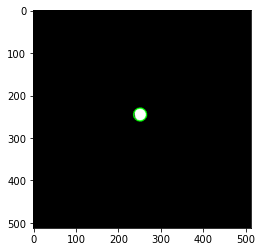

Num large circles 1
Circle (253, 242) 16


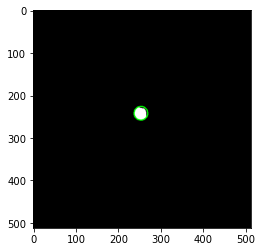

Num large circles 1
Circle (252, 242) 16


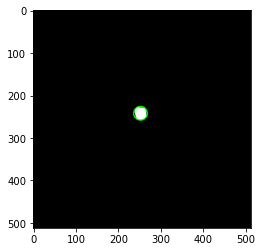

Num large circles 1
Circle (251, 242) 16


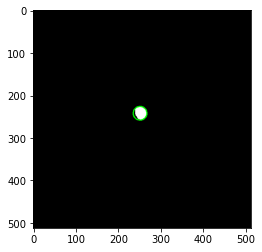

Num large circles 1
Circle (251, 239) 16


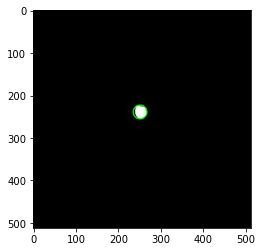

Num large circles 1
Circle (251, 239) 16


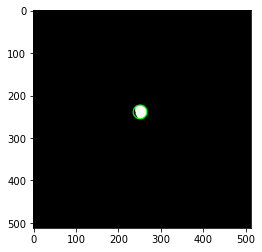

Num large circles 1
Circle (251, 239) 17


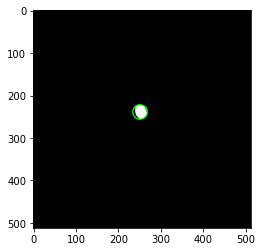

Num large circles 1
Circle (251, 238) 17


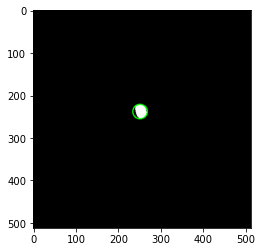

Num large circles 1
Circle (252, 236) 17


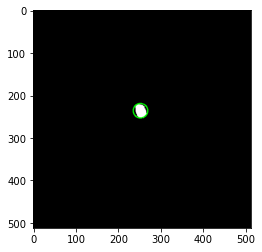

Num large circles 1
Circle (253, 235) 17


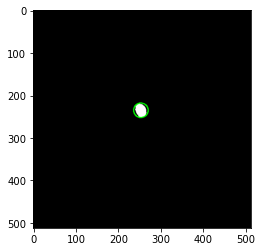

Num large circles 1
Circle (253, 235) 17


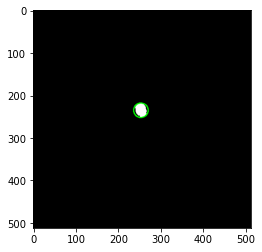

Num large circles 1
Circle (253, 234) 17


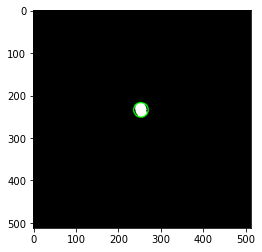

Num large circles 1
Circle (252, 234) 16


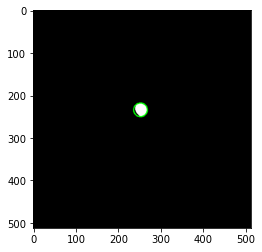

Num large circles 1
Circle (253, 233) 16


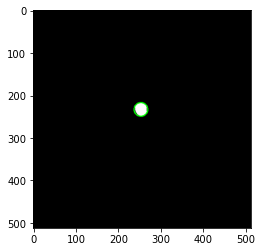

Num large circles 1
Circle (254, 232) 16


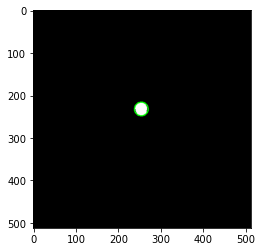

Num large circles 1
Circle (253, 231) 15


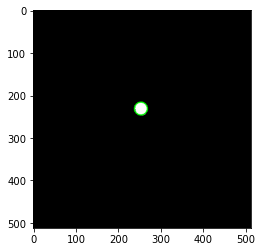

Num large circles 1
Circle (177, 232) 1
SKipping small circle


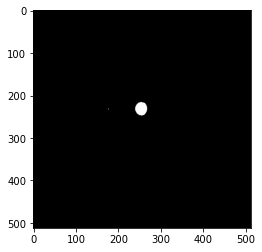

Circle (254, 231) 15


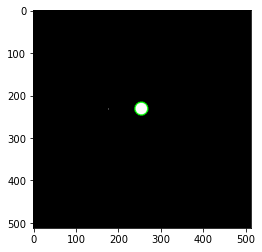

Num large circles 1
Circle (177, 231) 0
SKipping small circle


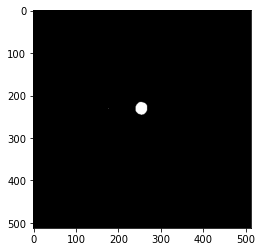

Circle (254, 230) 14


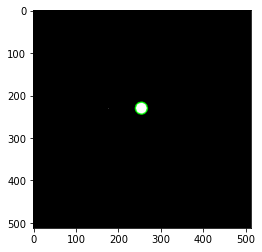

Num large circles 1
Circle (176, 230) 0
SKipping small circle


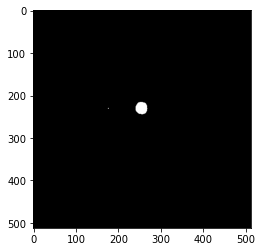

Circle (254, 229) 14


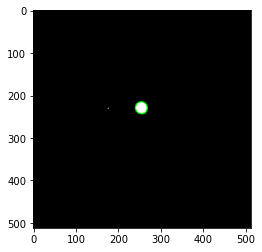

Num large circles 1
Circle (175, 229) 0
SKipping small circle


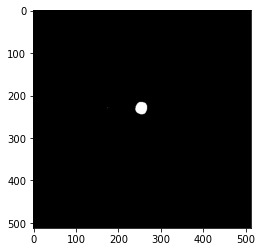

Circle (254, 229) 14


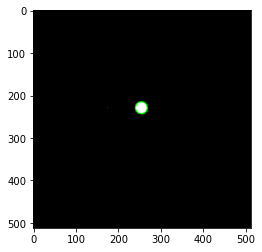

Num large circles 1
Circle (173, 227) 0
SKipping small circle


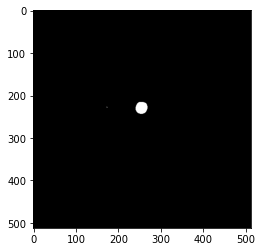

Circle (254, 229) 14


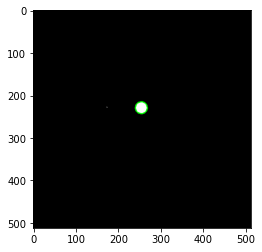

Num large circles 1
Circle (172, 227) 0
SKipping small circle


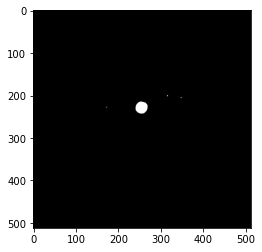

Circle (254, 228) 14


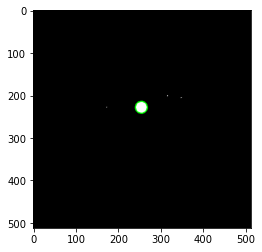

Circle (348, 205) 1
SKipping small circle


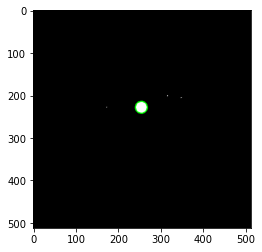

Circle (315, 201) 1
SKipping small circle


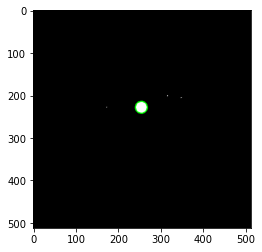

Num large circles 1
Circle (172, 227) 0
SKipping small circle


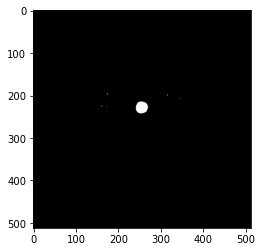

Circle (160, 224) 0
SKipping small circle


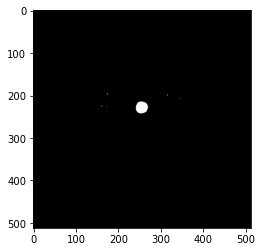

Circle (254, 228) 14


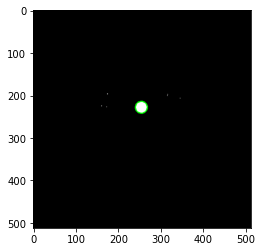

Circle (345, 206) 0
SKipping small circle


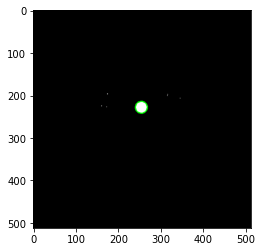

Circle (315, 200) 0
SKipping small circle


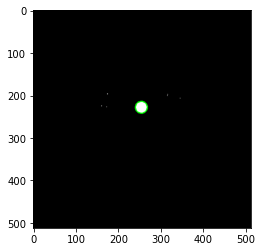

Circle (316, 197) 0
SKipping small circle


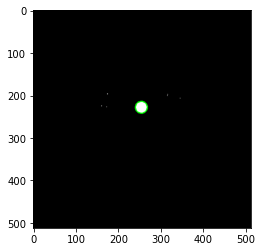

Circle (174, 196) 0
SKipping small circle


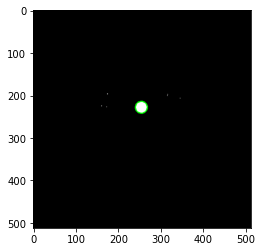

Num large circles 1
Circle (316, 237) 0
SKipping small circle


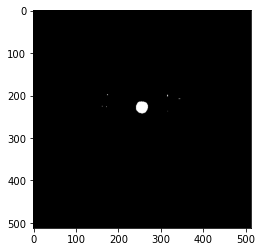

Circle (172, 226) 0
SKipping small circle


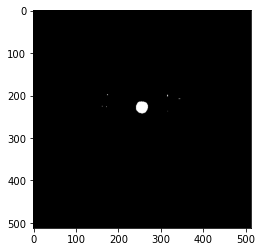

Circle (162, 225) 0
SKipping small circle


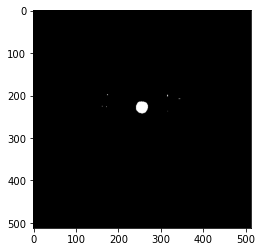

Circle (255, 227) 14


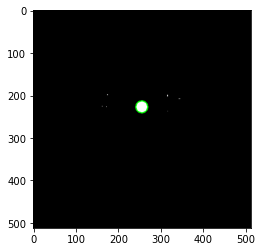

Circle (343, 208) 1
SKipping small circle


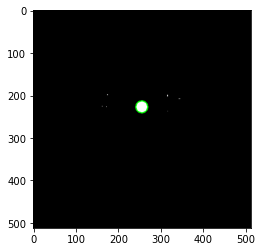

Circle (315, 200) 1
SKipping small circle


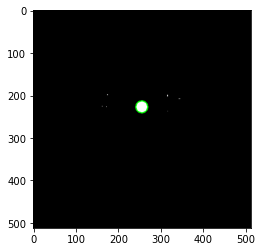

Circle (174, 198) 0
SKipping small circle


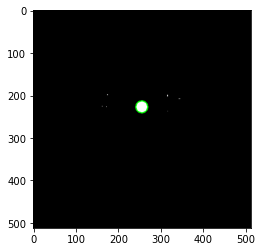

Num large circles 1
Circle (317, 237) 0
SKipping small circle


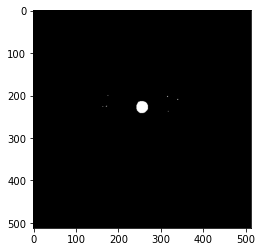

Circle (163, 226) 0
SKipping small circle


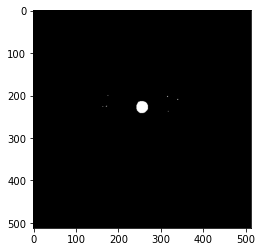

Circle (172, 225) 1
SKipping small circle


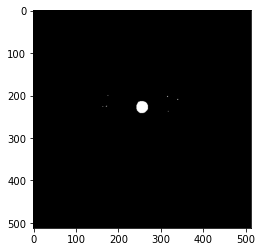

Circle (255, 227) 14


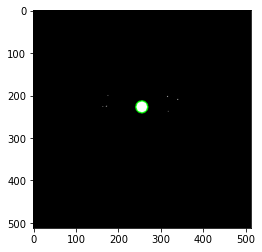

Circle (339, 209) 0
SKipping small circle


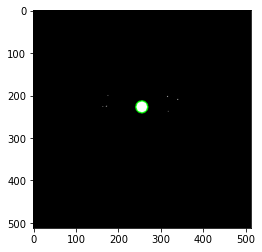

Circle (315, 202) 0
SKipping small circle


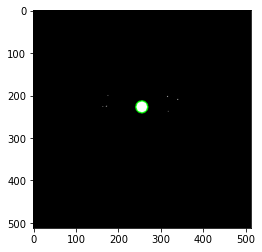

Circle (175, 200) 0
SKipping small circle


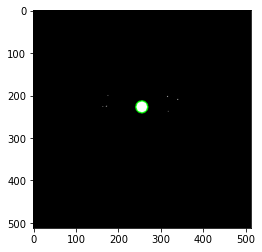

Num large circles 1
Circle (175, 269) 0
SKipping small circle


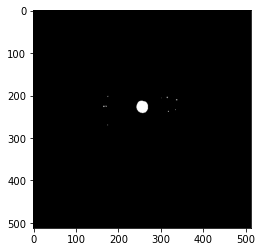

Circle (317, 237) 0
SKipping small circle


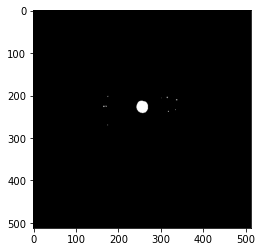

Circle (334, 233) 0
SKipping small circle


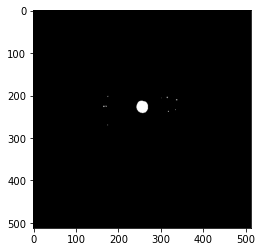

Circle (171, 225) 1
SKipping small circle


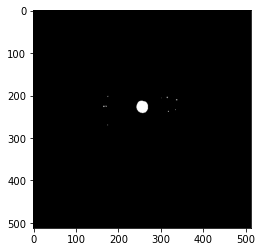

Circle (166, 225) 1
SKipping small circle


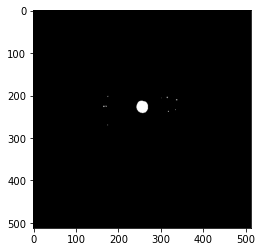

Circle (256, 227) 14


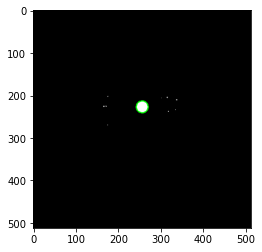

Circle (337, 210) 1
SKipping small circle


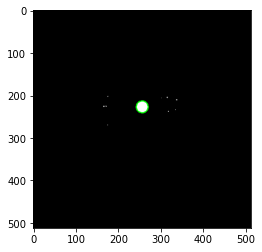

Circle (301, 206) 0
SKipping small circle


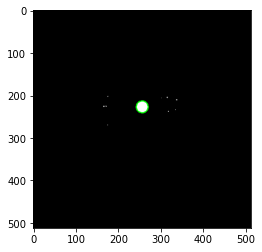

Circle (315, 204) 1
SKipping small circle


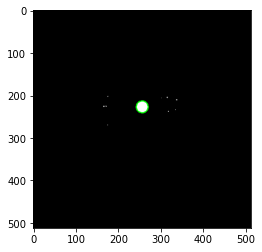

Circle (175, 202) 0
SKipping small circle


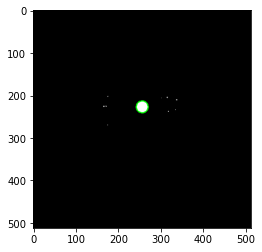

Num large circles 1
Circle (175, 268) 0
SKipping small circle


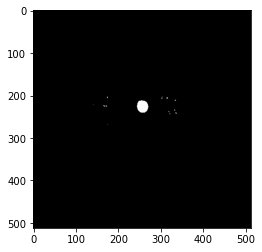

Circle (321, 243) 1
SKipping small circle


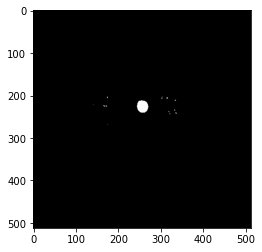

Circle (335, 241) 1
SKipping small circle


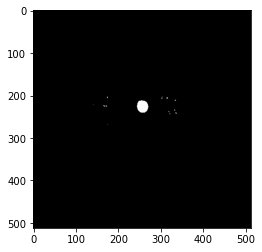

Circle (318, 238) 0
SKipping small circle


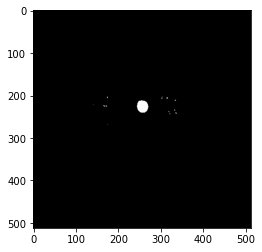

Circle (332, 234) 0
SKipping small circle


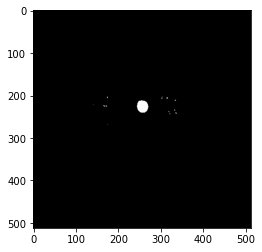

Circle (171, 225) 1
SKipping small circle


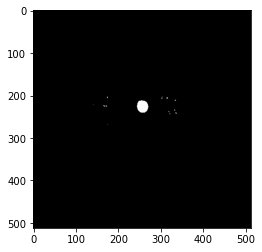

Circle (166, 225) 1
SKipping small circle


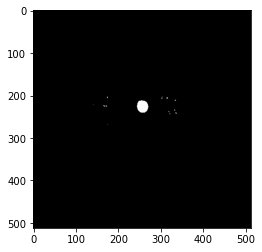

Circle (141, 222) 0
SKipping small circle


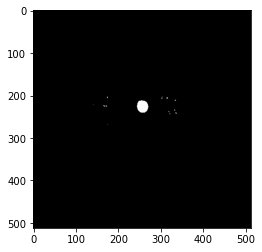

Circle (255, 226) 14


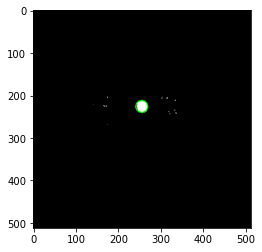

Circle (334, 211) 1
SKipping small circle


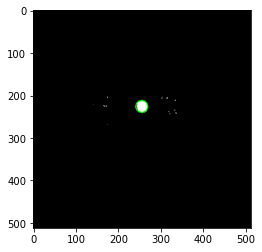

Circle (302, 206) 1
SKipping small circle


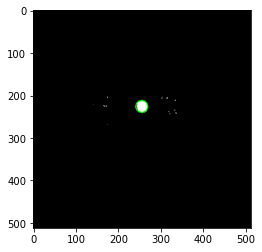

Circle (314, 206) 1
SKipping small circle


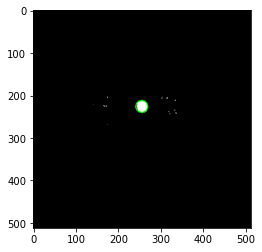

Circle (303, 203) 0
SKipping small circle


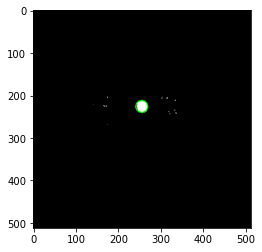

Circle (174, 204) 1
SKipping small circle


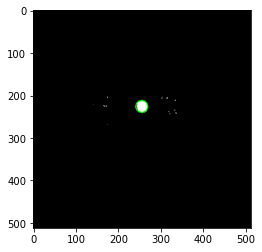

Num large circles 1
Circle (174, 266) 0
SKipping small circle


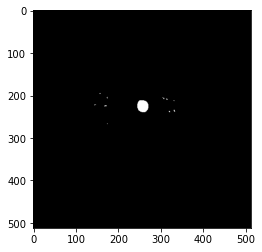

Circle (320, 238) 1
SKipping small circle


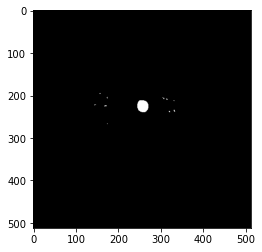

Circle (332, 236) 2
SKipping small circle


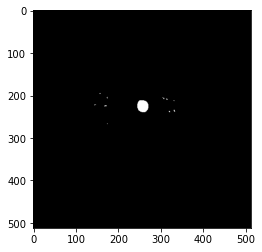

Circle (170, 225) 2
SKipping small circle


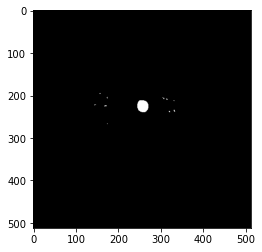

Circle (145, 222) 1
SKipping small circle


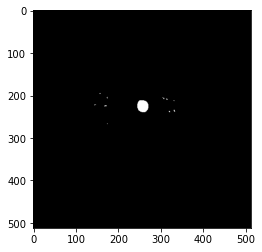

Circle (330, 212) 0
SKipping small circle


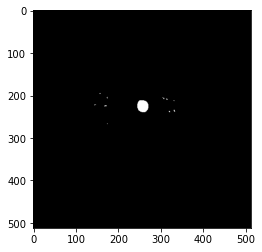

Circle (256, 225) 14


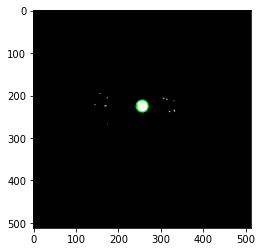

Circle (314, 209) 1
SKipping small circle


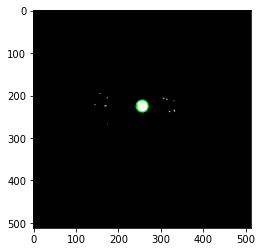

Circle (307, 207) 1
SKipping small circle


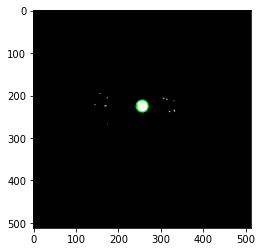

Circle (304, 205) 0
SKipping small circle


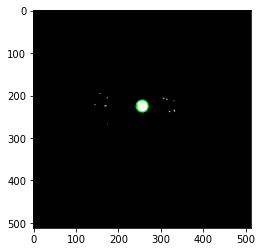

Circle (174, 205) 1
SKipping small circle


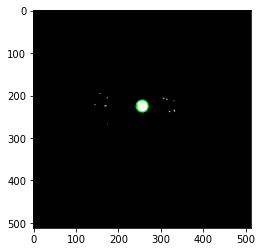

Circle (157, 196) 1
SKipping small circle


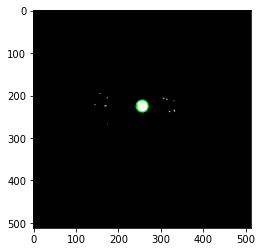

Num large circles 1
Circle (174, 266) 0
SKipping small circle


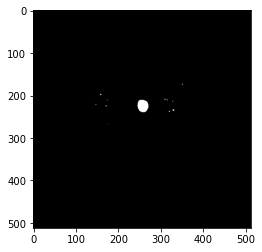

Circle (320, 237) 1
SKipping small circle


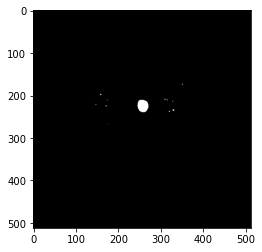

Circle (329, 234) 1
SKipping small circle


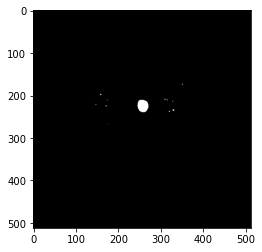

Circle (171, 224) 1
SKipping small circle


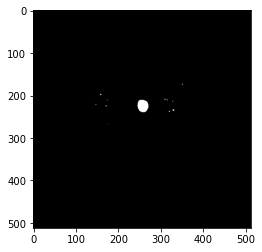

Circle (147, 221) 0
SKipping small circle


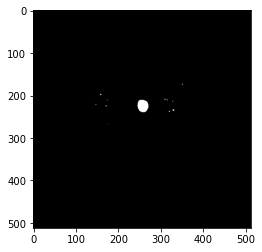

Circle (327, 213) 0
SKipping small circle


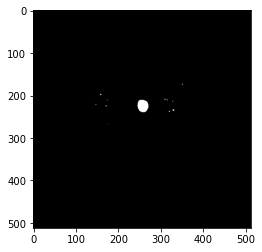

Circle (256, 225) 15


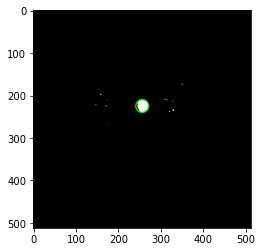

Circle (314, 210) 0
SKipping small circle


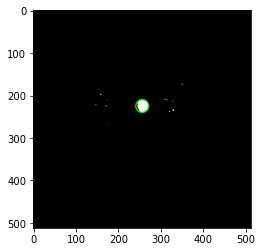

Circle (174, 210) 0
SKipping small circle


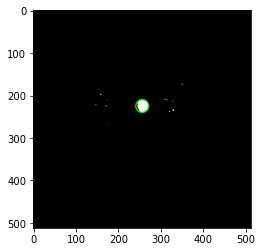

Circle (309, 209) 1
SKipping small circle


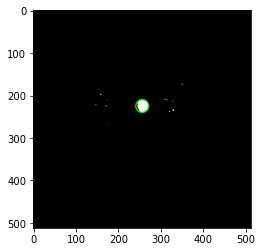

Circle (158, 198) 1
SKipping small circle


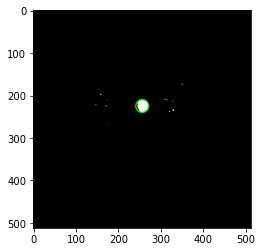

Circle (350, 174) 1
SKipping small circle


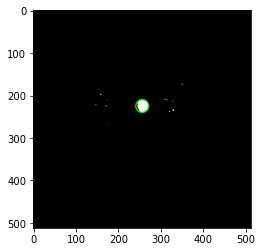

Num large circles 1
Circle (166, 271) 0
SKipping small circle


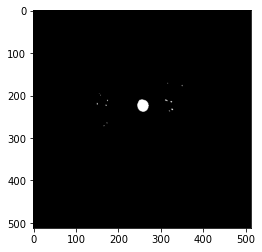

Circle (173, 264) 0
SKipping small circle


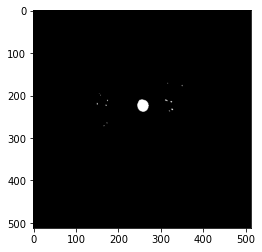

Circle (320, 236) 1
SKipping small circle


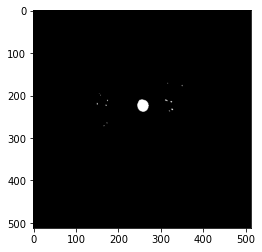

Circle (326, 232) 1
SKipping small circle


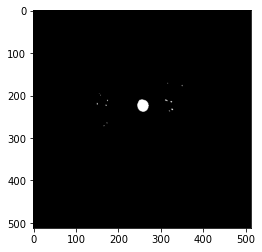

Circle (171, 223) 1
SKipping small circle


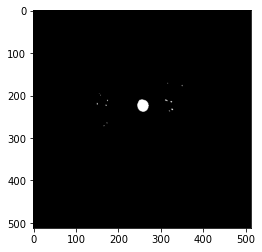

Circle (150, 219) 1
SKipping small circle


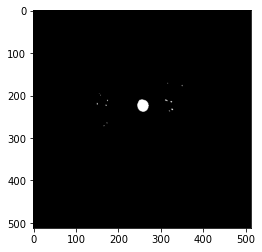

Circle (324, 214) 1
SKipping small circle


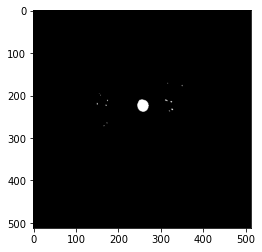

Circle (174, 212) 1
SKipping small circle


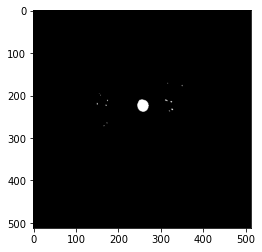

Circle (312, 212) 2
SKipping small circle


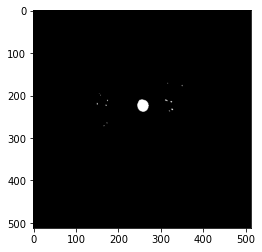

Circle (256, 224) 14


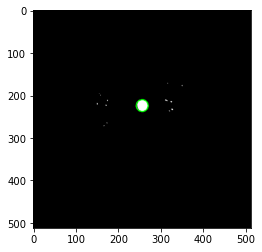

Circle (158, 199) 0
SKipping small circle


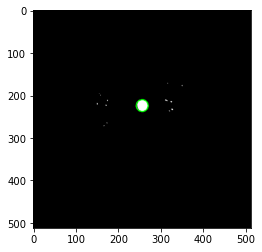

Circle (155, 196) 0
SKipping small circle


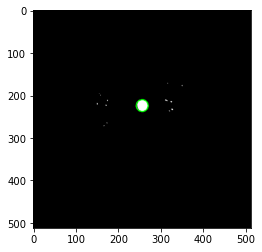

Circle (350, 177) 1
SKipping small circle


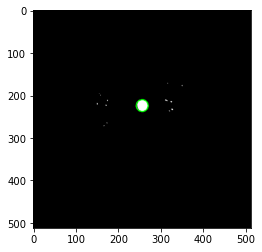

Circle (316, 171) 0
SKipping small circle


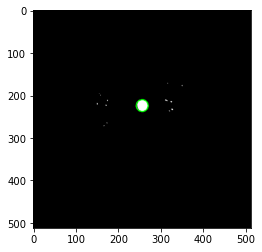

Num large circles 1
Circle (167, 267) 0
SKipping small circle


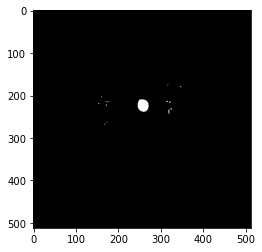

Circle (173, 263) 0
SKipping small circle


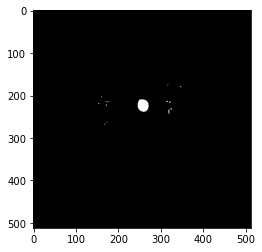

Circle (319, 239) 5
SKipping small circle


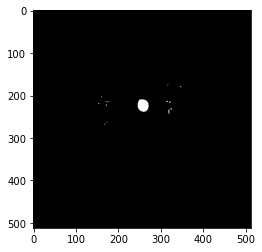

Circle (324, 231) 1
SKipping small circle


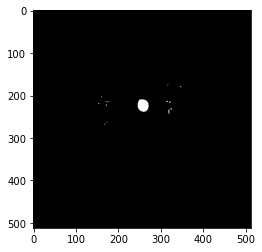

Circle (172, 223) 1
SKipping small circle


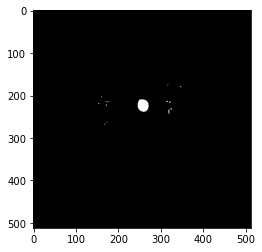

Circle (154, 219) 1
SKipping small circle


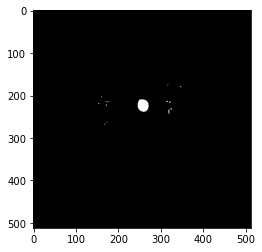

Circle (321, 216) 1
SKipping small circle


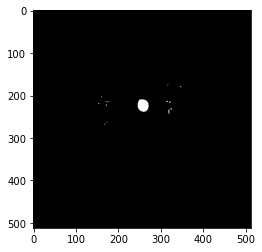

Circle (178, 215) 1
SKipping small circle


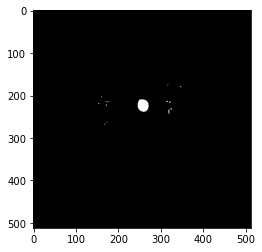

Circle (172, 214) 1
SKipping small circle


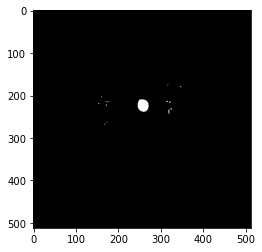

Circle (314, 214) 1
SKipping small circle


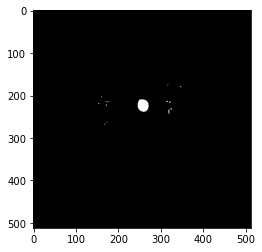

Circle (257, 224) 15


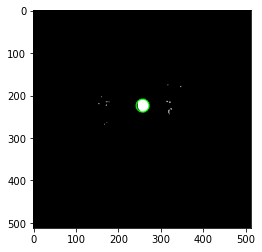

Circle (160, 203) 0
SKipping small circle


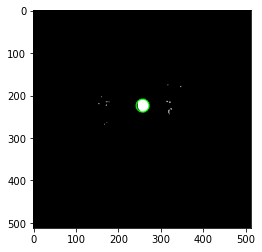

Circle (346, 179) 1
SKipping small circle


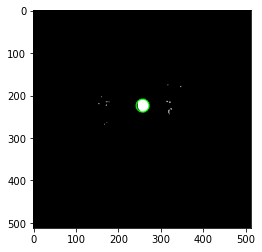

Circle (316, 175) 0
SKipping small circle


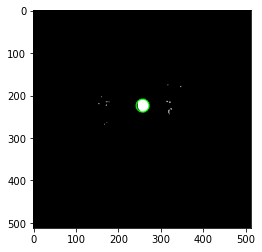

Num large circles 1
Circle (169, 264) 0
SKipping small circle


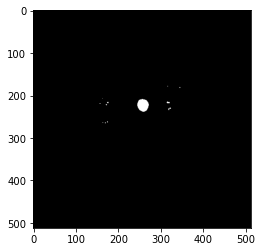

Circle (163, 264) 0
SKipping small circle


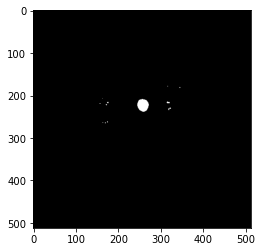

Circle (174, 262) 1
SKipping small circle


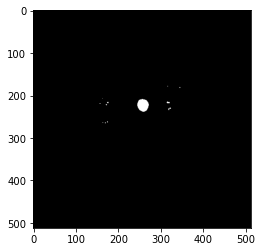

Circle (320, 231) 3
SKipping small circle


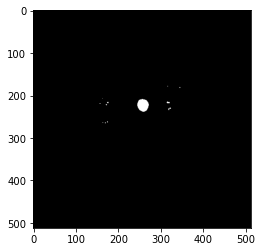

Circle (171, 221) 1
SKipping small circle


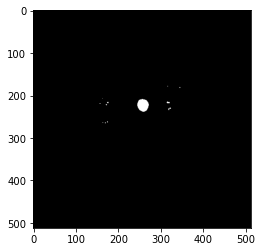

Circle (157, 219) 1
SKipping small circle


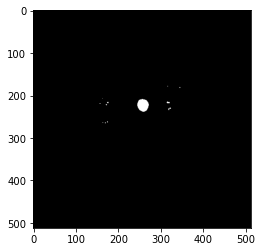

Circle (175, 216) 1
SKipping small circle


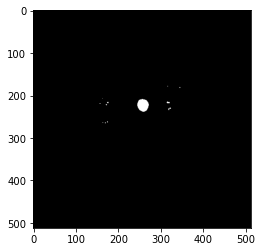

Circle (317, 217) 3
SKipping small circle


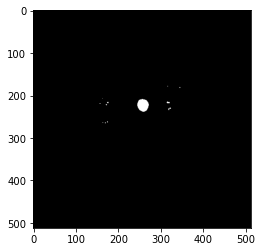

Circle (257, 223) 14


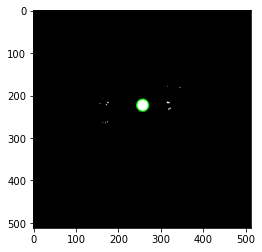

Circle (163, 207) 0
SKipping small circle


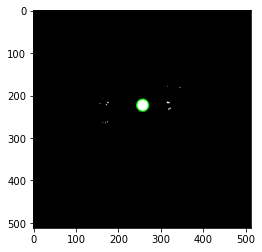

Circle (344, 181) 0
SKipping small circle


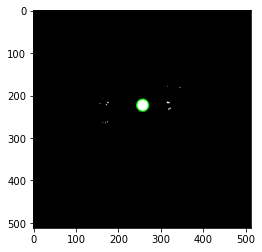

Circle (316, 178) 0
SKipping small circle


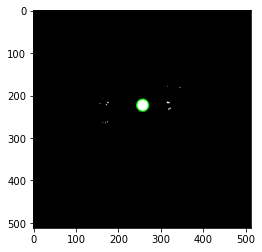

Num large circles 1
Circle (167, 262) 0
SKipping small circle


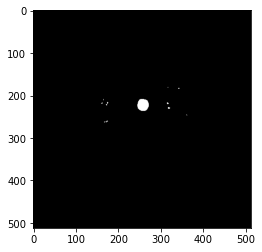

Circle (172, 261) 2
SKipping small circle


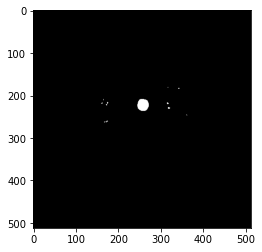

Circle (360, 246) 1
SKipping small circle


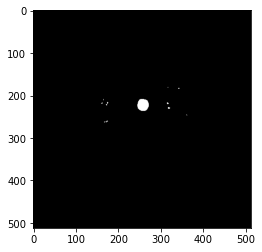

Circle (318, 229) 2
SKipping small circle


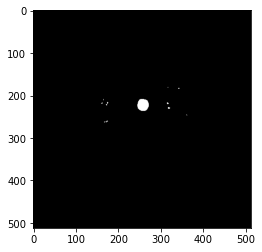

Circle (172, 222) 1
SKipping small circle


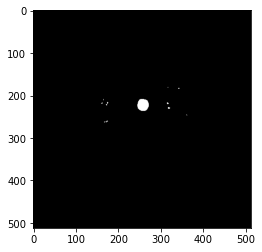

Circle (316, 218) 2
SKipping small circle


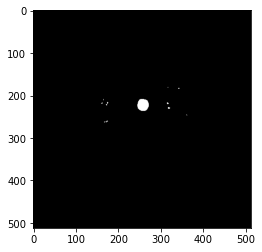

Circle (161, 218) 1
SKipping small circle


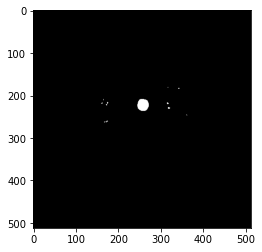

Circle (174, 217) 1
SKipping small circle


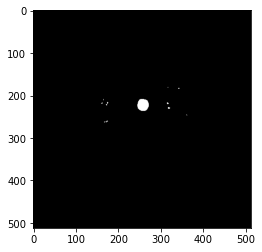

Circle (257, 222) 14


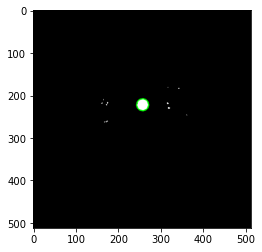

Circle (165, 210) 1
SKipping small circle


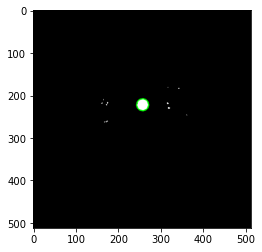

Circle (342, 183) 1
SKipping small circle


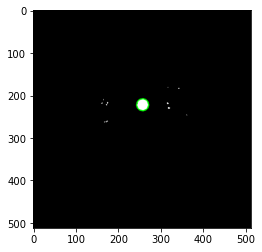

Circle (316, 181) 0
SKipping small circle


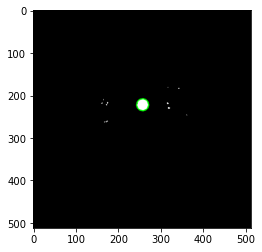

Num large circles 1
Circle (196, 299) 0
SKipping small circle


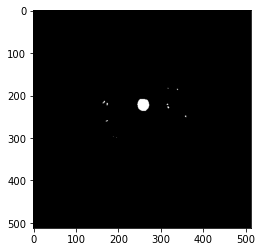

Circle (188, 297) 0
SKipping small circle


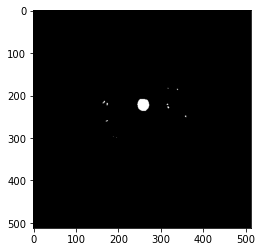

Circle (173, 260) 2
SKipping small circle


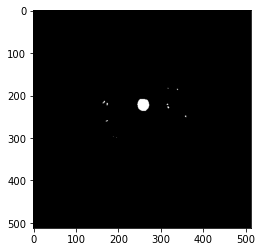

Circle (358, 249) 1
SKipping small circle


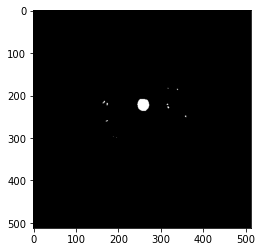

Circle (317, 228) 2
SKipping small circle


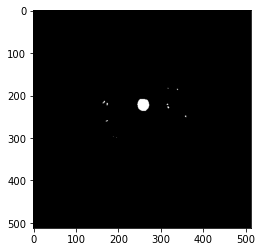

Circle (315, 221) 1
SKipping small circle


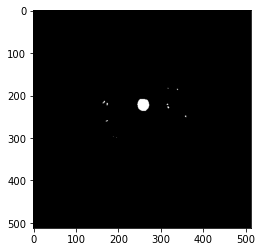

Circle (173, 220) 2
SKipping small circle


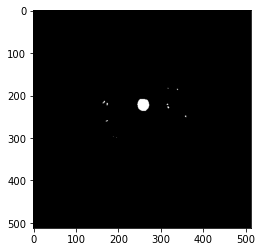

Circle (165, 215) 3
SKipping small circle


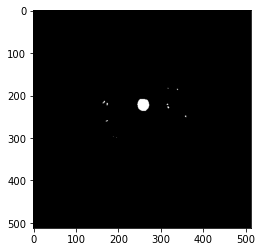

Circle (258, 222) 14


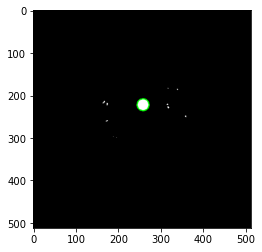

Circle (338, 185) 1
SKipping small circle


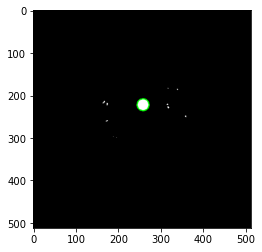

Circle (316, 183) 0
SKipping small circle


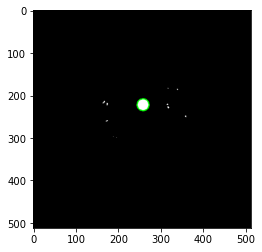

Num large circles 1
Circle (190, 290) 3
SKipping small circle


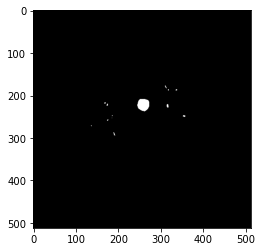

Circle (136, 271) 0
SKipping small circle


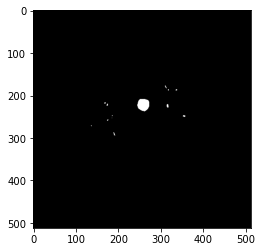

Circle (175, 258) 1
SKipping small circle


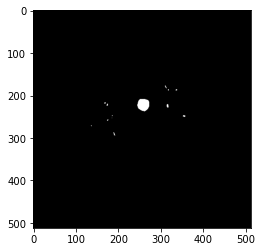

Circle (185, 253) 0
SKipping small circle


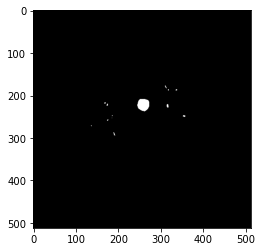

Circle (354, 248) 2
SKipping small circle


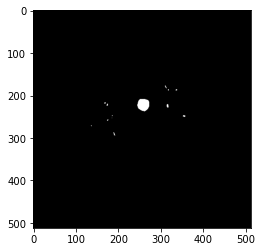

Circle (185, 247) 0
SKipping small circle


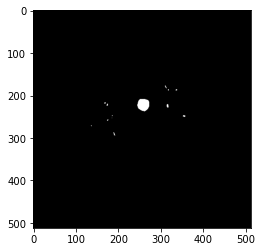

Circle (316, 224) 3
SKipping small circle


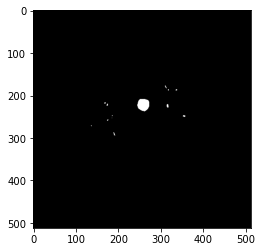

Circle (174, 222) 2
SKipping small circle


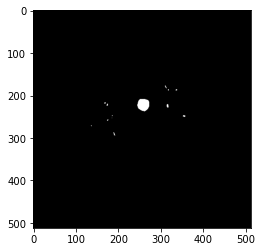

Circle (168, 217) 1
SKipping small circle


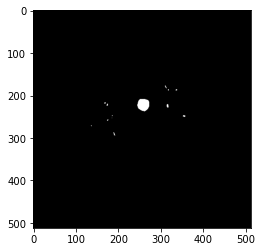

Circle (258, 222) 15


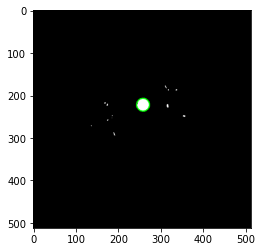

Circle (336, 187) 1
SKipping small circle


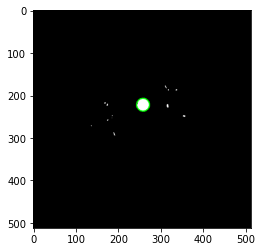

Circle (317, 187) 1
SKipping small circle


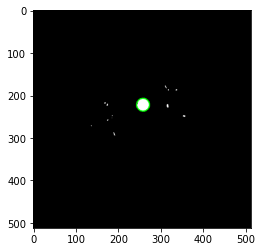

Circle (311, 180) 3
SKipping small circle


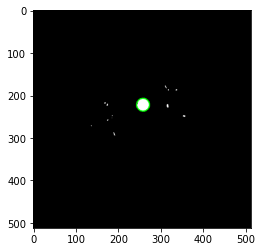

Num large circles 1
Circle (343, 283) 0
SKipping small circle


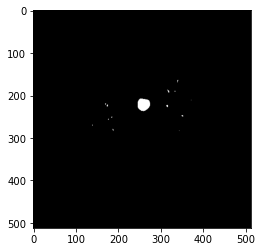

Circle (187, 281) 2
SKipping small circle


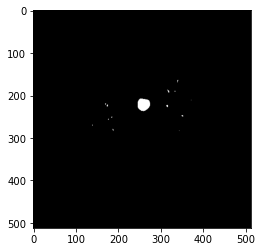

Circle (139, 270) 1
SKipping small circle


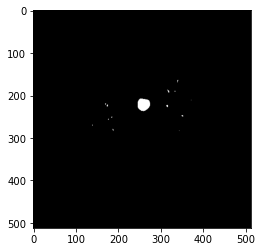

Circle (176, 256) 1
SKipping small circle


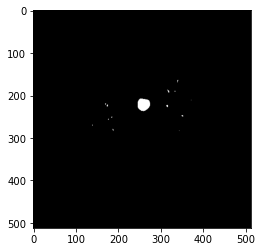

Circle (184, 251) 1
SKipping small circle


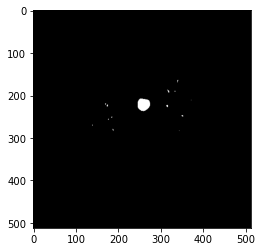

Circle (350, 248) 1
SKipping small circle


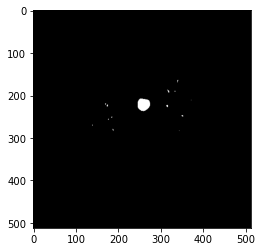

Circle (315, 225) 2
SKipping small circle


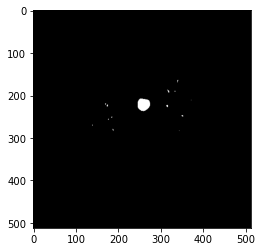

Circle (174, 224) 2
SKipping small circle


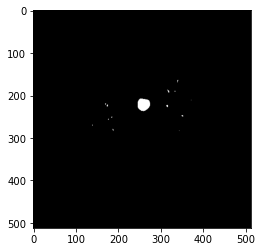

Circle (170, 220) 1
SKipping small circle


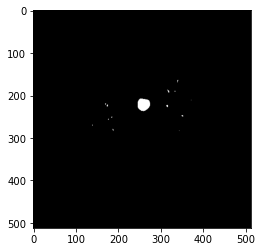

Circle (371, 211) 0
SKipping small circle


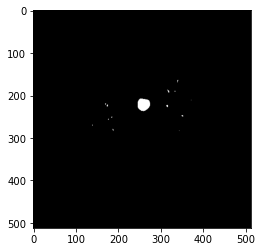

Circle (259, 221) 15


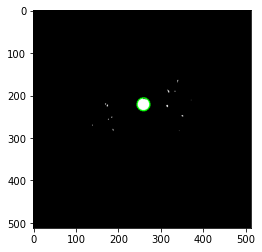

Circle (333, 190) 1
SKipping small circle


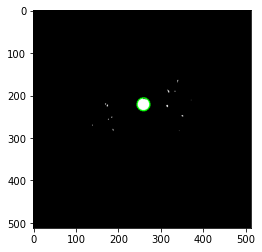

Circle (317, 190) 2
SKipping small circle


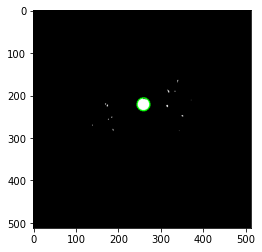

Circle (315, 186) 0
SKipping small circle


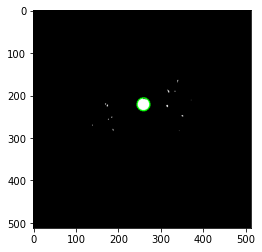

Circle (339, 166) 2
SKipping small circle


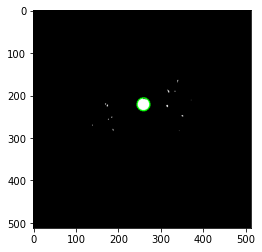

Num large circles 1
Circle (343, 278) 0
SKipping small circle


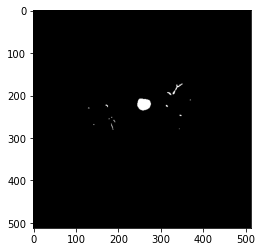

Circle (142, 268) 0
SKipping small circle


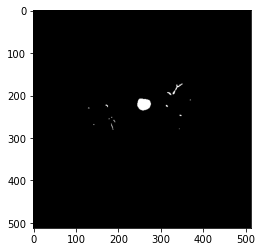

Circle (185, 273) 6
SKipping small circle


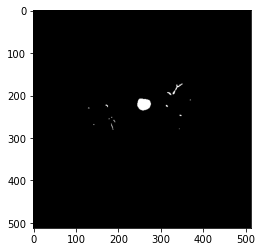

Circle (190, 260) 2
SKipping small circle


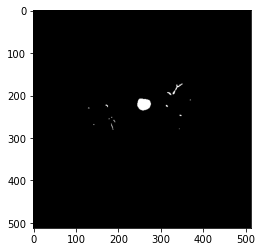

Circle (178, 255) 1
SKipping small circle


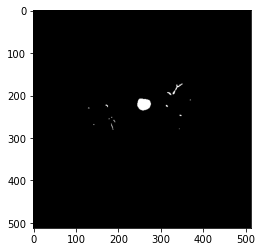

Circle (184, 251) 0
SKipping small circle


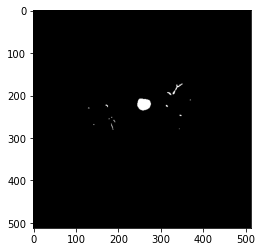

Circle (346, 247) 2
SKipping small circle


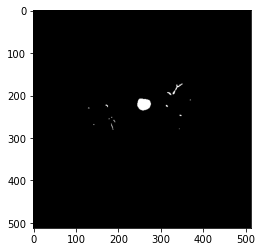

Circle (130, 230) 1
SKipping small circle


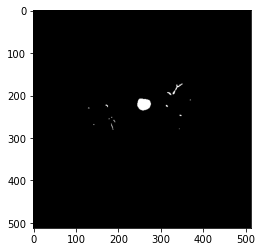

Circle (313, 224) 2
SKipping small circle


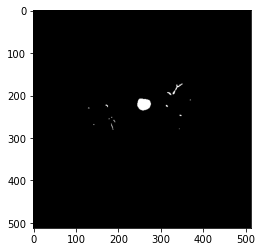

Circle (172, 224) 3
SKipping small circle


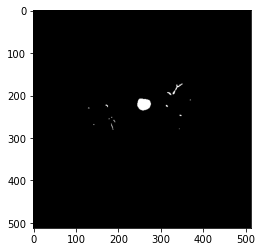

Circle (369, 211) 1
SKipping small circle


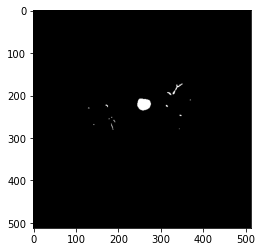

Circle (260, 220) 15


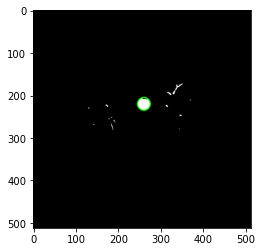

Circle (319, 196) 5
SKipping small circle


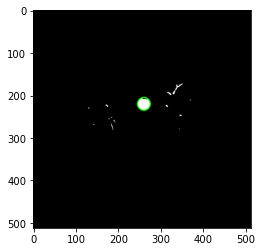

Circle (339, 185) 16


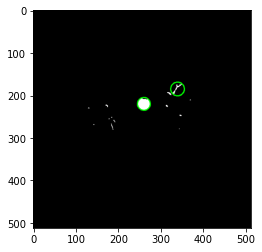

Num large circles 2
Breaking at loc 195


In [115]:
# TRY SHIFTING TO CARINA
def find_start_point(aw_img, loc=None):
    # function to find trachea
    # 1: find first slice with non zero pixels 
    # sum along z_axis
    img_array =  sitk.GetArrayFromImage(aw_img)
#     # binary image
   
#     img_array[np.where(img_array==255)] = 1
    size = img.GetSize()
    spacing = img.GetSpacing()

    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if loc is None:
        z = img_array.sum(axis=(1,2))
        loc = np.argmax(z> 0) # index of first non-zero slice
        print("First non zero slice", loc)
    
    # get that slice and display it
    _slice = cv2.cvtColor(img_array[loc,:,:], cv2.COLOR_GRAY2RGB)
    cv2_img = img_array[loc,:,:]

    # top down
#     f, (ax1, ax2) = plt.subplots(2)
#     ax1.imshow(_slice, cmap='gray')
    # find the contours
    contours, hierarchy = cv2.findContours(cv2_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     assert len(contours) == 1, f"Unexpected number of contours {len(contours)}"
    # Use a list to store the center and radius of the target circles:
    # cv2.imshow('Circles', _slice)
    # Look for the outer contours:
    num_large_circles = 0
    centers = []
    radii = []
    for i, c in enumerate(contours):
        # Approximate the contour to a circle:
        (x, y), radius = cv2.minEnclosingCircle(c)
        # Compute the center and radius:
        center = (int(x), int(y))
        radius = int(radius)
        print("Circle",center,radius)
        centers.append(center)
        radii.append(radius)
    #     # Draw the circles:
        if radius <8:
            print('SKipping small circle')
        else:
            num_large_circles +=1
            cv2.circle(_slice, center, radius, (0, 255, 0), 2)
        
        plt.imshow(_slice)
        plt.show()
    print('Num large circles', num_large_circles)
    
    return centers, radii, loc, num_large_circles

num_large_circles = 0

for i in range(0,300,5):
    centers, radii, loc, num_large_circles = find_start_point(aw_img, loc=i)
    if num_large_circles > 1:
        print("Breaking at loc", loc)
        break

ValueError: setting an array element with a sequence.

No parent
No parent
No parent


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z
0,3010007,Trachea,104.9620,351.5130,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,10,249,275,103,252.0,251.0,1.0
1,3010007,LMB,51.0142,148.6810,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,6,280,277,143,249.0,275.0,103.0
2,3010007,RMB,25.4442,215.5690,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,8,231,273,121,249.0,275.0,103.0
3,3010007,BronInt,29.8319,111.9830,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,5,219,274,148,231.0,273.0,121.0
4,3010007,RUL,16.6494,75.6966,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,4,218,273,111,231.0,273.0,121.0


In [16]:
(tree_w_coords.radius == 0) # 55x 0 radius what to do


0      False
1      False
2      False
3      False
4      False
       ...  
376     True
377    False
378    False
379     True
380     True
Name: radius, Length: 381, dtype: bool

In [17]:
v = np.array([0,0,-1]).astype('int64')
not_v = np.array([1, 0, 0]).astype('int64')
if (v == not_v).all():
    not_v = np.array([0, 1, 0]).astype('int64')
# make vector perpendicular to v
n1 = np.cross(v.astype('int64'), not_v.astype('int64')).astype('float64')
print(n1)
# normalize n1
print(scipy.linalg.norm(n1.astype('int64')))
n1 /= scipy.linalg.norm(n1)

[ 0. -1.  0.]
1.0


Building tree:   0%|          | 0/30 [00:00<?, ?it/s]

LMB 3.0 start/end/r [223 260 220] [241 258 202] 6
[[223.         260.         220.        ]
 [222.95701379 259.995282   219.95753801]
 [222.91402758 259.990564   219.91507602]
 ...
 [236.8303374  257.54235411 197.88118695]
 [236.78735119 257.53763611 197.83872496]
 [236.74436498 257.53291811 197.79626297]]
RMB 2.0 start/end/r [223 260 220] [268 259 189] 8
[[223.         260.         220.        ]
 [222.95414099 259.99785483 219.93349966]
 [222.90828197 259.99570966 219.86699932]
 ...
 [263.5516756  258.7919183  182.54946721]
 [263.50581658 258.78977313 182.48296688]
 [263.45995757 258.78762795 182.41646654]]
BronInt 4.0 start/end/r [268 259 189] [231 258 188] 5
[[268.         259.         189.        ]
 [267.99807101 259.03568641 189.03568641]
 [267.99614201 259.07137281 189.07137281]
 ...
 [230.81288749 261.46158135 191.46158135]
 [230.8109585  261.49726776 191.49726776]
 [230.8090295  261.53295417 191.53295417]]
RUL 5.0 start/end/r [268 259 189] [273 264 262] 4
[[268.         259.   

LB4 31.0 start/end/r [285 263 183] [298 265 180] 2
[[285.         263.         183.        ]
 [284.99460078 263.01079843 182.98380235]
 [284.98920157 263.02159687 182.9676047 ]
 ...
 [297.47627595 266.0474481  178.42882785]
 [297.47087673 266.05824653 178.4126302 ]
 [297.46547752 266.06904497 178.39643255]]


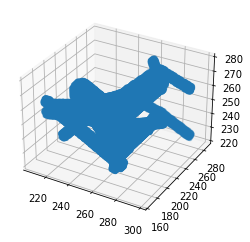

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

In [211]:
# two cross sections at diff slices - > simple linear interp of centers radius interp between first slice and last --> draw filled in circles inside image on each slice
# section may not be aligned with the slice - reorient + rotate 

# defining mask
image = np.zeros(shape=img_array.shape, dtype=np.uint8)
# print(image.shape)
# start= np.array([startz, startx, starty])
# end= tree_w_coords.loc[tree_w_coords.endbpid == 1][['z','x', 'y']].values.squeeze()

# set radius and centres values
# r = tree_w_coords.loc[tree_w_coords.endbpid == 1]['radius'].item()
# print(start, end, r)

def get_cyllinder(start, end, radius):
    p1 = np.array(start)
    p2 = np.array(end)
    r = radius
    # # calculate p2-p1 distance
    # dx = p2[0] - p1[0]
    # dy = p2[1] - p1[1]
    # dz = p2[2] - p1[2]
    # dist = math.sqrt(dx**2 + dy**2 + dz**2)

    # vector in direction of axis
    v = p2 - p1
    # find magnitude of vector
    mag = scipy.linalg.norm(v)
    # unit vector in direction of axis
    v = v / mag
    # make some vector not in the same direction as v
    not_v = np.array([1, 0, 0])
    if (v == not_v).all():
        not_v = np.array([0, 1, 0])
        
    try:
        # make vector perpendicular to v
        n1 = np.cross(v, not_v).astype('float64')
        # normalize n1
        n1 /= scipy.linalg.norm(n1)
        # make unit vector perpendicular to v and n1
        n2 = np.cross(v, n1).astype('float64')
        #volume ranges over t from 0 to length of axis and 0 to 2*pi
        t = np.linspace(0, mag, 100)
        theta = np.linspace(0, 2 * np.pi, 90)
        rsample = np.linspace(0, r, 100)

        #use meshgrid to make 2d arrays
        t, theta2, rsample2 = np.meshgrid(t, theta,rsample)
        # print("here", t, theta, rsample2)
    # rsample, theta = np.meshgrid(rsample, theta)

        # generate coordinates for surface
        # "Tube"
        X, Y, Z = [p1[i] + v[i] * t + rsample2* np.sin(theta2) * n1[i] + rsample2 * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
    #     print(Z.shape, X.shape)
        # "Bottom"
        # X2, Y2, Z2 = [p1[i] + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        # "Top"
        # X3, Y3, Z3 = [p1[i] + v[i] * mag + rsample[i] * np.sin(theta) * n1[i] + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        # replaced mag with 1
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111, projection='3d')
        # ax.plot_surface(X, Y, Z)
        # ax.plot_surface(X2, Y2, Z2)
        # ax.plot_surface(X3, Y3, Z3)

    # plt.show()

        tube = np.stack((X.ravel(), Y.ravel(), Z.ravel()), axis=1)
    except:
        print(f"A problem occurred, skipping segment: {start, end, radius}")
        tube = None
        
    return tube

image = np.zeros(shape=img_array.shape)
# face1 = np.stack((X2.ravel(), Y2.ravel(), Z2.ravel()), axis=1)
# face2 = np.stack((X3.ravel(), Y3.ravel(), Z3.ravel()), axis=1)
# filling numpy mask
def _fill_tube(image, tube):
    for i in range(len(tube)):
        image[int(tube[i][0]), int(tube[i][1]), int(tube[i][2])] = 255
    return image

for i in tqdm(range(len(tree_w_coords.head(30))), desc='Building tree'):
    # set radius and centres values
    row = tree_w_coords.iloc[i]
    r = row['radius'].item()
    
    start =  np.array(row[['parent_loc_z','parent_loc_y', 'parent_loc_x']].values.squeeze()).astype('int64')
    end= np.array(row[['z','y', 'x']].values.squeeze()).astype('int64')
    print(row.anatomicalname, row.endbpid,'start/end/r', start, end, r)
    if r == 0:
        print("0 radius: skipping segment")
        continue
    tube = get_cyllinder(start, end, r)
    print(tube)
    if tube is not None:
        try:
            image = _fill_tube(image, tube)
        except:
            print(tube)
    


# for j in range(len(face1)):
#     image[int(face1[j][0]), int(face1[j][1]), int(face1[j][2])] = 1

# for k in range(len(face2)):
#     image[int(face2[k][0]), int(face2[k][1]), int(face2[k][2])] = 1





fig=plt.figure()
ax = fig.add_subplot(projection='3d')
xs, ys, zs = np.where(image==255)
ax.scatter(xs, zs, ys)


plt.show()

# def fill_convex(arr):
#     for i in range(arr.shape[0]):
#         for j in range(arr.shape[1]):
#             mask = slice(None), slice(i, i + 1), slice(j, j + 1)
# #             print("mask",mask)
#             line = arr[mask]
#             k = np.where(line > 0)[0]
#             if len(k):
#                 start, stop = np.min(k), np.max(k)
#                 line[start:stop] = 1
#     return arr

def fill_contours(arr):
    l_r = np.maximum.accumulate(arr).astype(bool)
    r_l = np.maximum.accumulate(arr[:,::-1])[:,::-1].astype(bool)
    return l_r & r_l
# THERE ARE ERRORS HERE! : Nan issue with vectors to figure out, lengths seem smaller --> 


overlay = sitk.GetImageFromArray(image.astype('uint8'),isVector=False)
# MAYBE SOMETHING WRONG HERE --> DOUBLE CHECK WHAT EXACTLY YOU'RE doing when matching these
overlay.SetOrigin(aw_img.GetOrigin())
overlay.SetDirection(aw_img.GetDirection())

interactive_view(sitk.LabelOverlay(aw_img, overlay))

In [19]:
interactive_view(sitk.LabelOverlay(aw_img, overlay))

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

In [43]:

fig=plt.figure()
ax = fig.add_subplot(projection='3d')
xs, ys, zs = np.where(image==0)
print(xs)
print(ys)
print(zs)
# ax.set_xlim(0, image.shape[0])
# ax.set_ylim(0, image.shape[1])
# ax.set_zlim(0, image.shape[2])
ax.scatter(zs, xs, ys)
plt.show()

[  0   0   0 ... 669 669 669]
[  0   0   0 ... 511 511 511]
[  0   1   2 ... 509 510 511]


KeyboardInterrupt: 

In [21]:
print(aw_img.GetPixelIDTypeAsString())
print(lung_img.GetPixelIDTypeAsString())
print(overlay.GetPixelIDTypeAsString())


8-bit unsigned integer
8-bit unsigned integer
8-bit unsigned integer


In [22]:
theta = np.linspace(0,2*np.pi,180)
z = np.linspace(-100,100,100)
X, Y, Z = [p1[i] + v[i] * t + r * np.sin(theta2) * n1[i] + r * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
coords = np.meshgrid(x,y,z)

NameError: name 'p1' is not defined

In [ ]:
np.where(sitk.GetArrayFromImage(overlay)==1)

In [ ]:
np.array(list(np.where(image==1))).sum(axis=0).argmax()

In [ ]:
# bps=np.mgrid[0:3,0:3,0:3]

bps[np.where((bps[0] < 2) & (bps[1] > 1))]=100
print(bps[0])
# start = (1,1,1)
# end = (4,3,5)
# r = 2
print(out)
print(out.shape)
print(img_array.shape)

In [ ]:
# convert into numpy array
branch_points = np.zeros_like(img_array)
print(tree_w_coords.iloc[0][['z','x','y']])
branch_points[(tree_w_coords.z.values, tree_w_coords.x.values,tree_w_coords.y.values)]=255
bp_img = sitk.GetImageFromArray(branch_points)
bp_img.SetOrigin(aw_img.GetOrigin())
bp_img.SetDirection(aw_img.GetDirection())
print(bp_img.GetDirection(), aw_img.GetDirection())
interactive_view(label_overlay(aw_img, bp_img))

[ 49  51  57  59  62  64  65  69  72  73  74  75  76  77  79  80  81  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 108 109 110 111 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 130 131 132 133 134 136 137 138 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 158 159 160 161 162 163 164
 165 166 167 168 170 171 172 173 174 175 176 178 179 180 181 182 183 184
 185 186 187 189 190 191 192 193 194 195 196 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 213 214 215 216 219 220 221 222 224 227 228
 229 230 231 233 235 236 238 240 241 242 243 244 246 251 252 253 254 255
 256 257 258 261 265 270 281]


idno                  3010007
anatomicalname        BronInt
centerlinelength      29.8319
avginnerarea          111.983
lobe                      0.0
sublobe                   0.0
endbpid                   4.0
startbpid                 2.0
angle                 160.312
dircosx             -0.417837
dircosy              0.018167
dircosz              0.908341
weibel_generation           2
radius                      5
x                         219
y                         274
z                         148
parent_loc_x            231.0
parent_loc_y            273.0
parent_loc_z            121.0
Name: 3, dtype: object

z_value 148
center (274, 219)


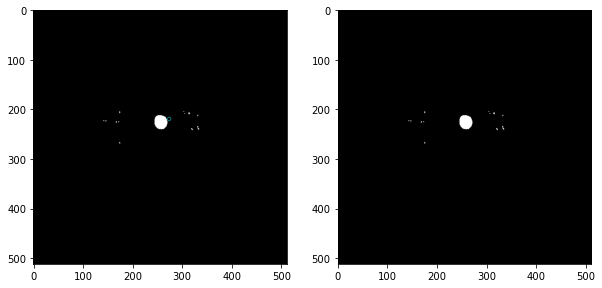

In [98]:
z_options, freq = np.unique(tree_w_coords.z.values, return_counts=True)
print(z_options)
def _display_slice(img_array, df_slice, value=0):
     #displays slice of image with circled branch point
    display(df_slice)
    print("z_value", df_slice.z.item())
    _slice = cv2.cvtColor(img_array[df_slice.z.item(), :,:], cv2.COLOR_GRAY2RGB)
    cv2_img = _slice #np.zeros_like(_slice)
    plt.show()
    center = (df_slice['y'], df_slice['x'])
    radius = int(df_slice['radius'])
    print("center", center)
    cv2.circle(cv2_img, center, 4, (0, 255, 255), 1)
    # plt.figure(figsize=(20,20))
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(cv2_img)
    ax2.imshow(img_array[df_slice.z.item(), :,:], cmap='gray')
    plt.show()


bp = tree_w_coords.iloc[3]
_display_slice(img_array, bp)

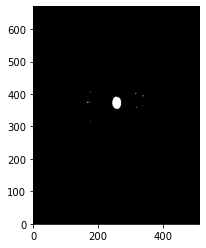

In [56]:
plt.imshow(img_array[140,:,:], origin='upper', cmap='gray', extent=(0, height, 0, depth))

0 255
Slice 50
(< cv2.KeyPoint 0x7f3381e1d030>,)
Number of Circular Blobs: 1


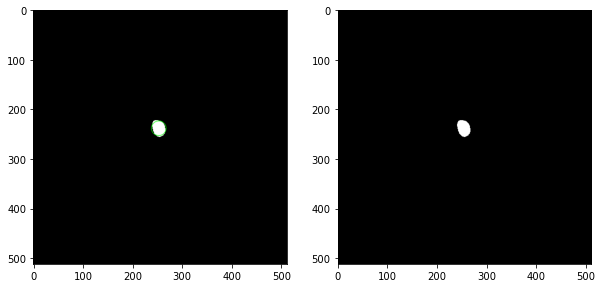

0 255
Slice 52
(< cv2.KeyPoint 0x7f334ae06630>,)
Number of Circular Blobs: 1


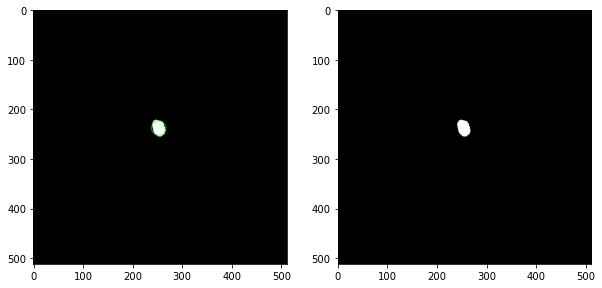

0 255
Slice 54
(< cv2.KeyPoint 0x7f3420dbafc0>,)
Number of Circular Blobs: 1


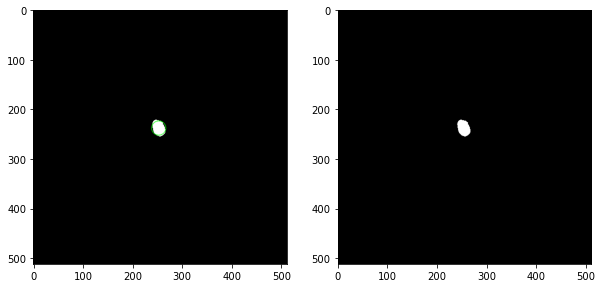

0 255
Slice 56
(< cv2.KeyPoint 0x7f334bb29bd0>,)
Number of Circular Blobs: 1


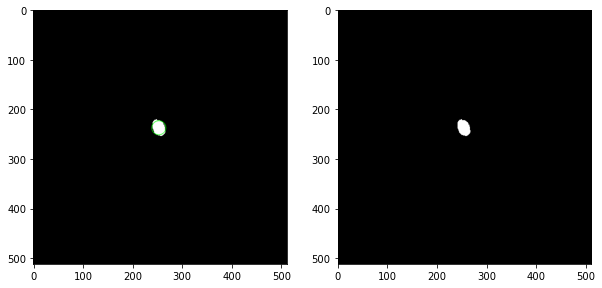

0 255
Slice 58
(< cv2.KeyPoint 0x7f334b598d50>,)
Number of Circular Blobs: 1


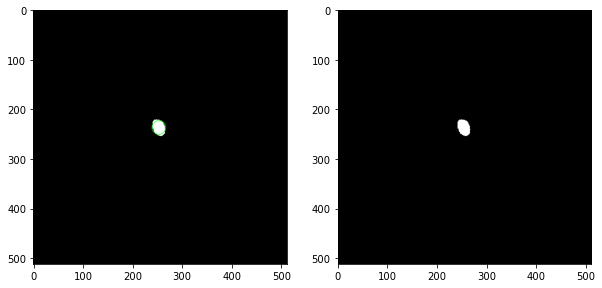

0 255
Slice 60
(< cv2.KeyPoint 0x7f334b12acf0>,)
Number of Circular Blobs: 1


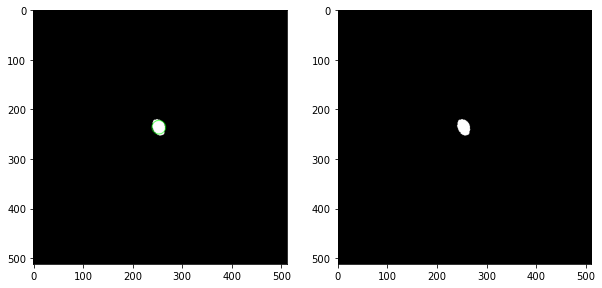

0 255
Slice 62
(< cv2.KeyPoint 0x7f334b8d2600>,)
Number of Circular Blobs: 1


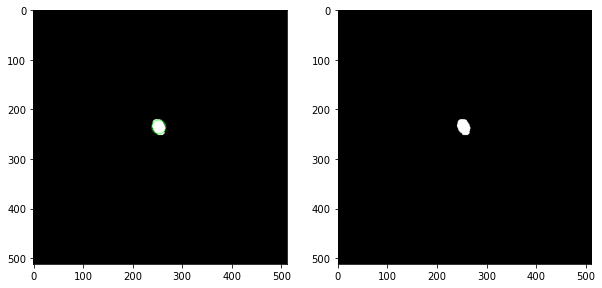

0 255
Slice 64
(< cv2.KeyPoint 0x7f3420ea7cf0>,)
Number of Circular Blobs: 1


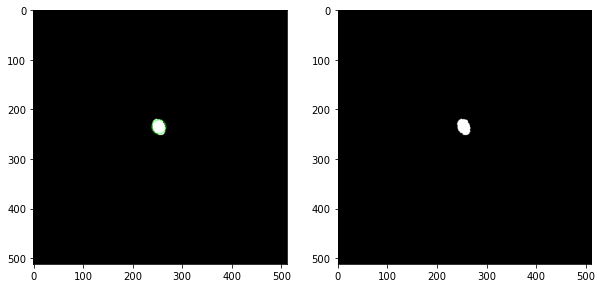

0 255
Slice 66
(< cv2.KeyPoint 0x7f3420e938a0>,)
Number of Circular Blobs: 1


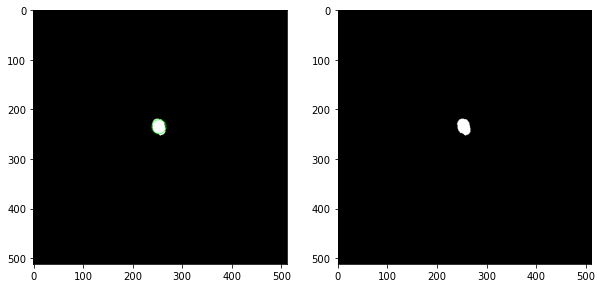

0 255
Slice 68
(< cv2.KeyPoint 0x7f334b6739c0>,)
Number of Circular Blobs: 1


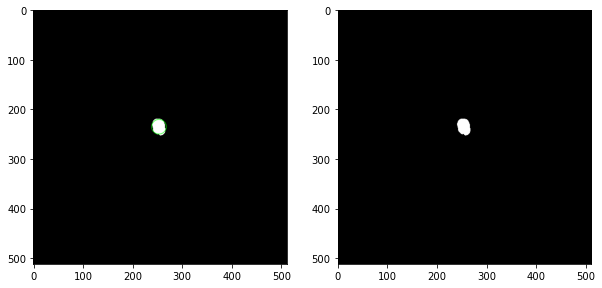

0 255
Slice 70
(< cv2.KeyPoint 0x7f334b1d9b40>,)
Number of Circular Blobs: 1


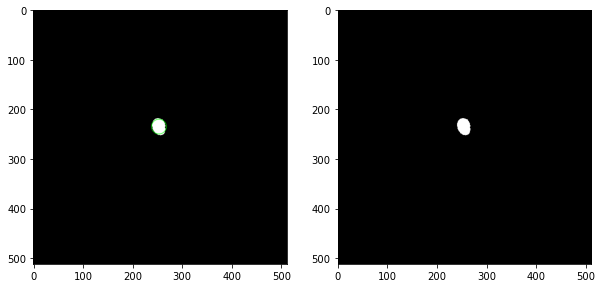

0 255
Slice 72
(< cv2.KeyPoint 0x7f334b6766f0>,)
Number of Circular Blobs: 1


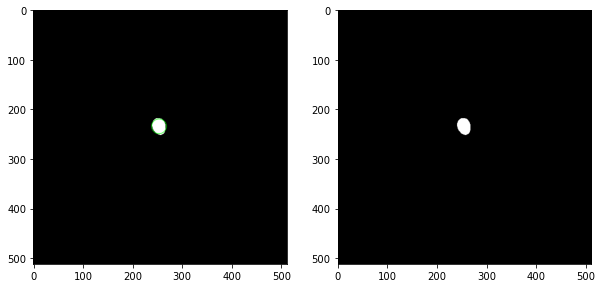

0 255
Slice 74
(< cv2.KeyPoint 0x7f334ba40750>,)
Number of Circular Blobs: 1


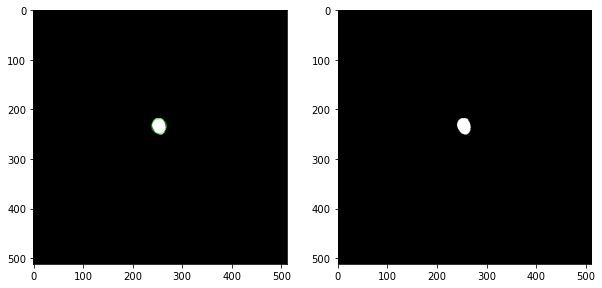

0 255
Slice 76
(< cv2.KeyPoint 0x7f334be77c30>,)
Number of Circular Blobs: 1


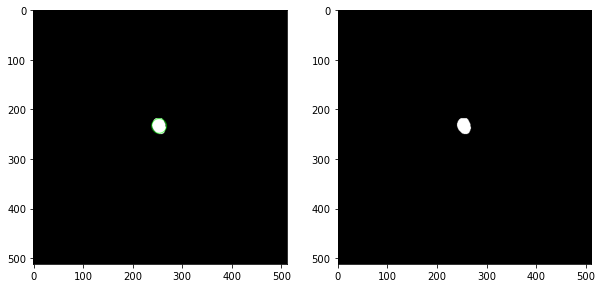

0 255
Slice 78
(< cv2.KeyPoint 0x7f334bd2f1b0>,)
Number of Circular Blobs: 1


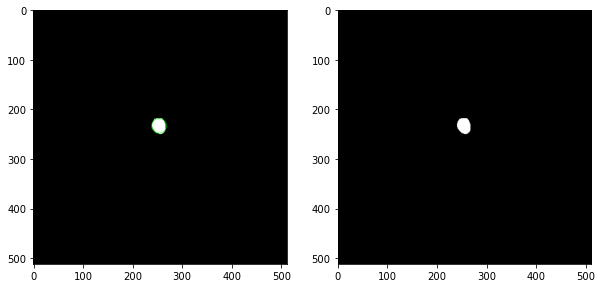

0 255
Slice 80
(< cv2.KeyPoint 0x7f334be3ec90>,)
Number of Circular Blobs: 1


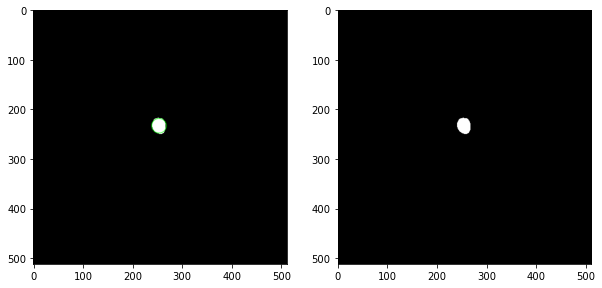

0 255
Slice 82
(< cv2.KeyPoint 0x7f334b0f2db0>,)
Number of Circular Blobs: 1


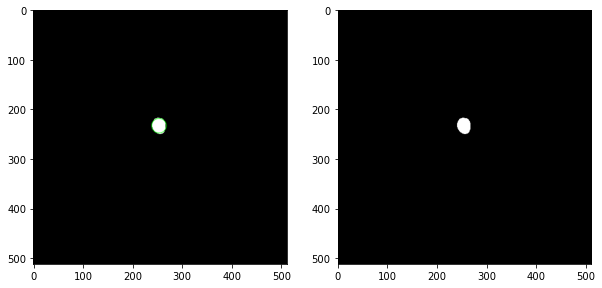

0 255
Slice 84
(< cv2.KeyPoint 0x7f334ae1a7e0>,)
Number of Circular Blobs: 1


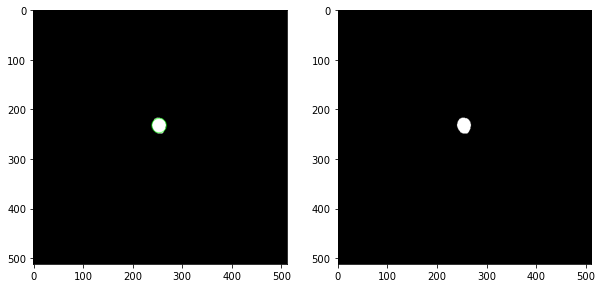

0 255
Slice 86
(< cv2.KeyPoint 0x7f338009b660>,)
Number of Circular Blobs: 1


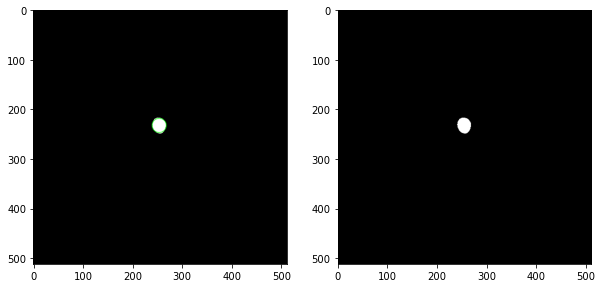

0 255
Slice 88
(< cv2.KeyPoint 0x7f334bd51ea0>,)
Number of Circular Blobs: 1


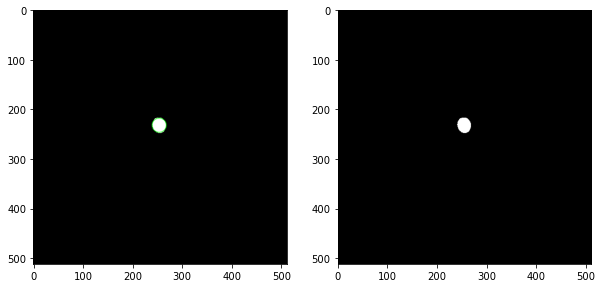

0 255
Slice 90
(< cv2.KeyPoint 0x7f33806600f0>,)
Number of Circular Blobs: 1


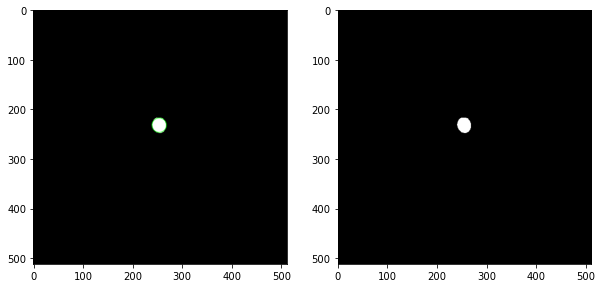

0 255
Slice 92
(< cv2.KeyPoint 0x7f3381e03600>,)
Number of Circular Blobs: 1


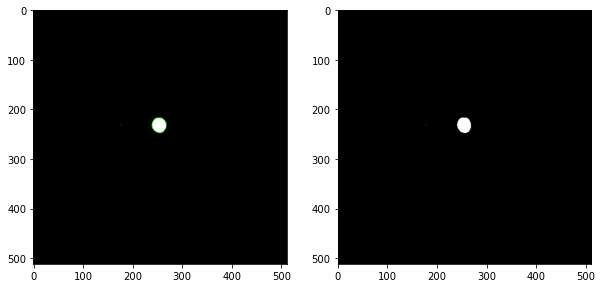

0 255
Slice 94
(< cv2.KeyPoint 0x7f338019e030>,)
Number of Circular Blobs: 1


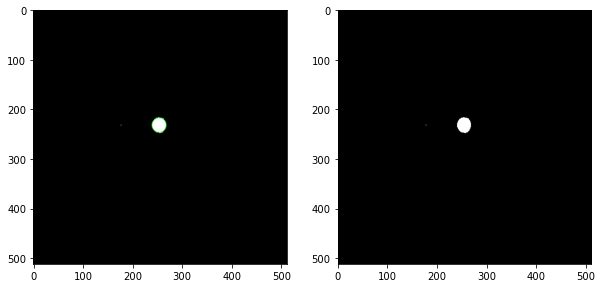

0 255
Slice 96
(< cv2.KeyPoint 0x7f3380516e70>,)
Number of Circular Blobs: 1


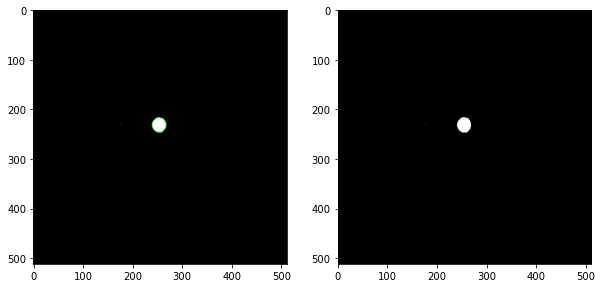

0 255
Slice 98
(< cv2.KeyPoint 0x7f334b43d840>,)
Number of Circular Blobs: 1


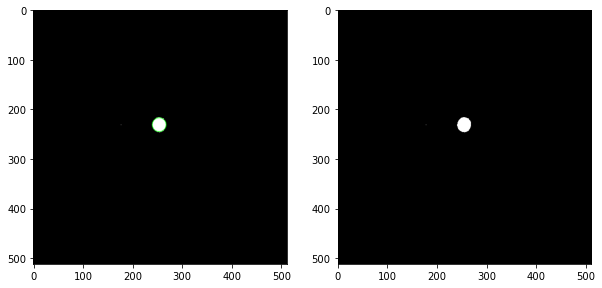

0 255
Slice 100
(< cv2.KeyPoint 0x7f334b8f3030>,)
Number of Circular Blobs: 1


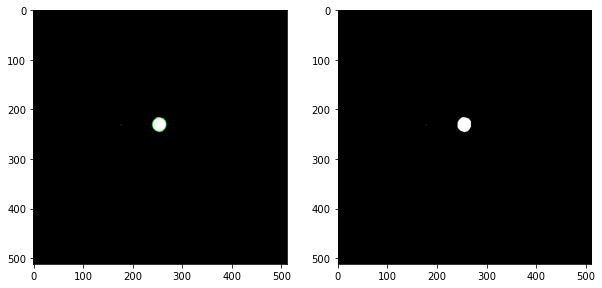

0 255
Slice 102
(< cv2.KeyPoint 0x7f334b9da300>,)
Number of Circular Blobs: 1


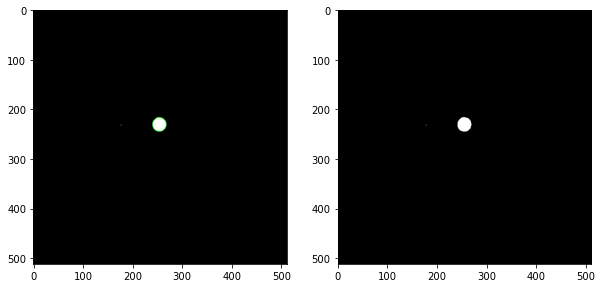

0 255
Slice 104
(< cv2.KeyPoint 0x7f334b902630>,)
Number of Circular Blobs: 1


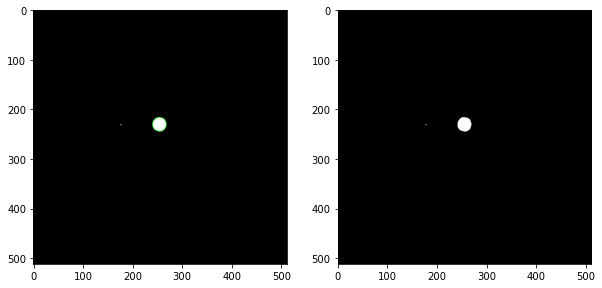

0 255
Slice 106
(< cv2.KeyPoint 0x7f334b390030>,)
Number of Circular Blobs: 1


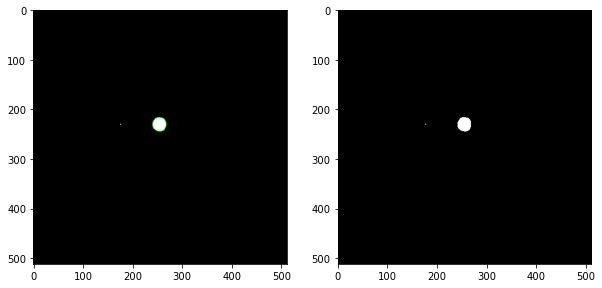

0 255
Slice 108
(< cv2.KeyPoint 0x7f3420faf300>,)
Number of Circular Blobs: 1


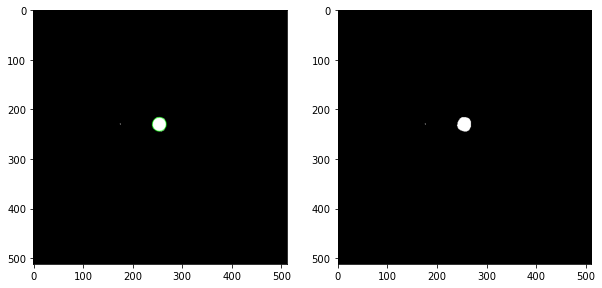

0 255
Slice 110
(< cv2.KeyPoint 0x7f3420e6b870>,)
Number of Circular Blobs: 1


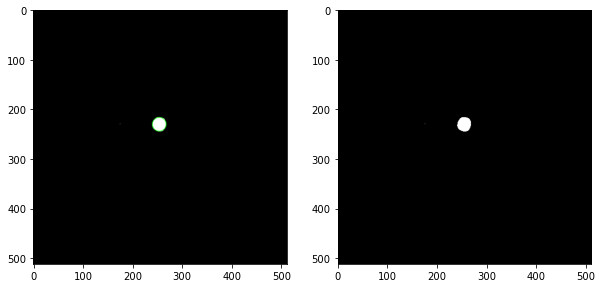

0 255
Slice 112
(< cv2.KeyPoint 0x7f334b02c150>,)
Number of Circular Blobs: 1


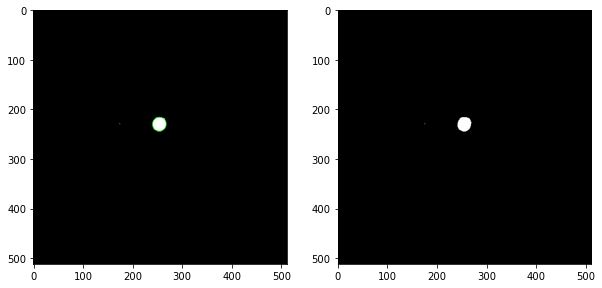

0 255
Slice 114
(< cv2.KeyPoint 0x7f334ae05990>,)
Number of Circular Blobs: 1


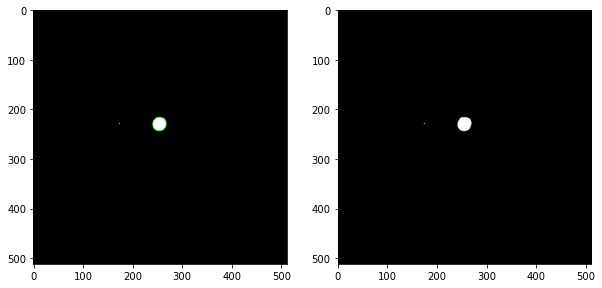

0 255
Slice 116
(< cv2.KeyPoint 0x7f334ba87c60>,)
Number of Circular Blobs: 1


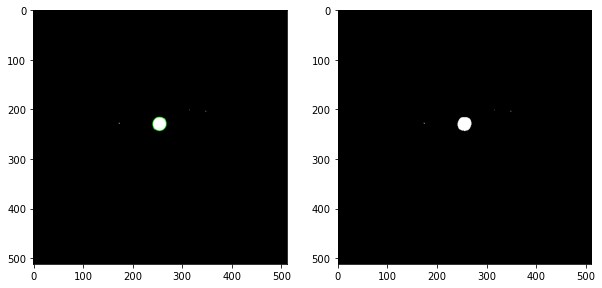

0 255
Slice 118
(< cv2.KeyPoint 0x7f334ae9e150>,)
Number of Circular Blobs: 1


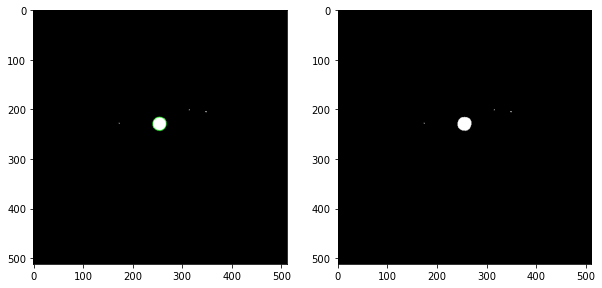

0 255
Slice 120
(< cv2.KeyPoint 0x7f334b5c22a0>,)
Number of Circular Blobs: 1


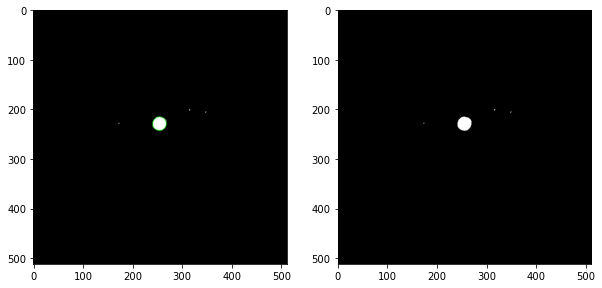

0 255
Slice 122
(< cv2.KeyPoint 0x7f334b739cf0>,)
Number of Circular Blobs: 1


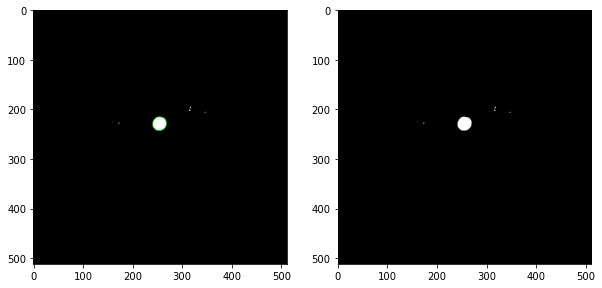

0 255
Slice 124
(< cv2.KeyPoint 0x7f334b24aab0>,)
Number of Circular Blobs: 1


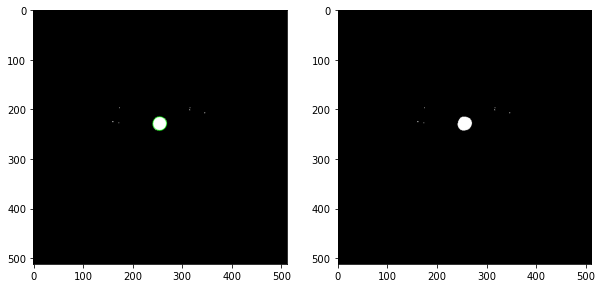

0 255
Slice 126
(< cv2.KeyPoint 0x7f334ba272a0>,)
Number of Circular Blobs: 1


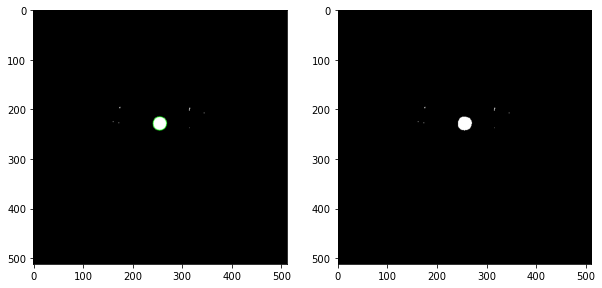

0 255
Slice 128
(< cv2.KeyPoint 0x7f334af8ac60>,)
Number of Circular Blobs: 1


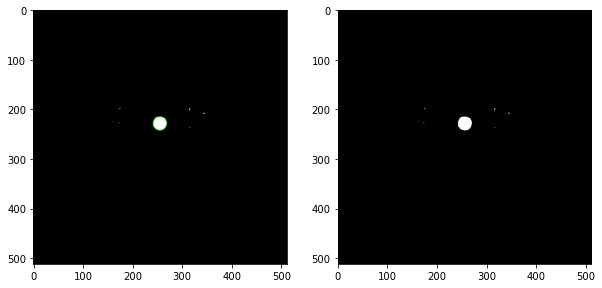

0 255
Slice 130
(< cv2.KeyPoint 0x7f334afc16f0>,)
Number of Circular Blobs: 1


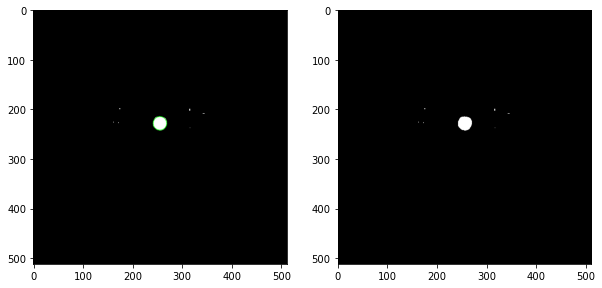

0 255
Slice 132
(< cv2.KeyPoint 0x7f33805690f0>,)
Number of Circular Blobs: 1


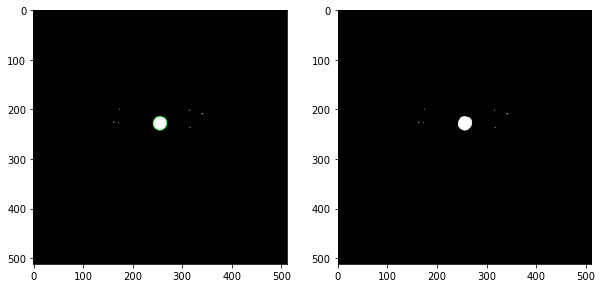

0 255
Slice 134
(< cv2.KeyPoint 0x7f334bdd2960>,)
Number of Circular Blobs: 1


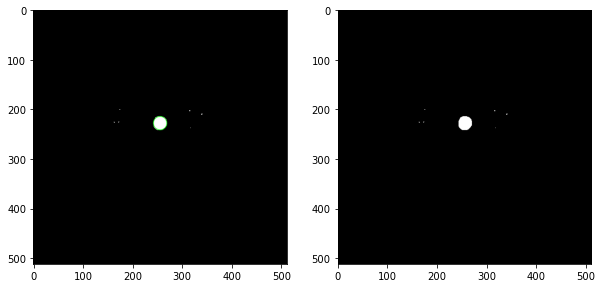

0 255
Slice 136
(< cv2.KeyPoint 0x7f3381eee330>,)
Number of Circular Blobs: 1


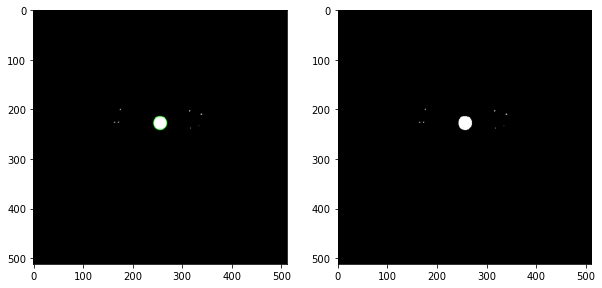

0 255
Slice 138
(< cv2.KeyPoint 0x7f338011b3f0>,)
Number of Circular Blobs: 1


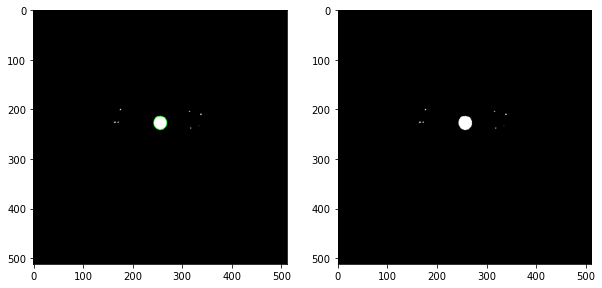

0 255
Slice 140
(< cv2.KeyPoint 0x7f33801cdf00>,)
Number of Circular Blobs: 1


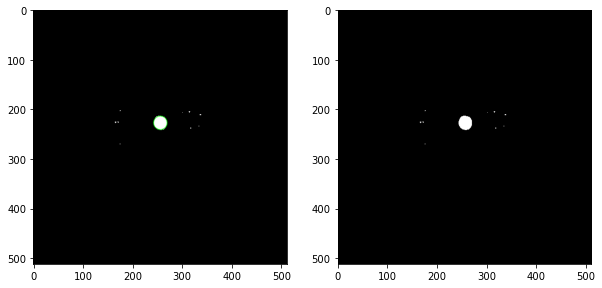

0 255
Slice 142
(< cv2.KeyPoint 0x7f3420e46e10>,)
Number of Circular Blobs: 1


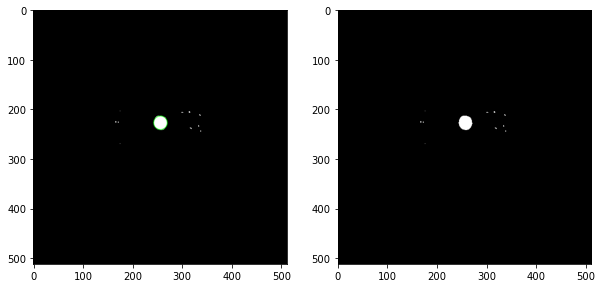

0 255
Slice 144
(< cv2.KeyPoint 0x7f3381ecc870>,)
Number of Circular Blobs: 1


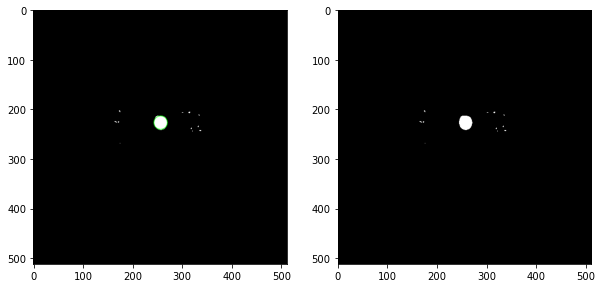

0 255
Slice 146
(< cv2.KeyPoint 0x7f334bce5db0>,)
Number of Circular Blobs: 1


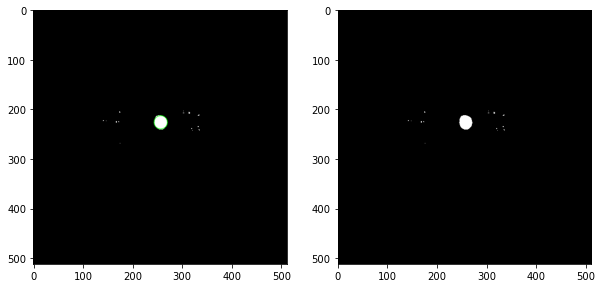

0 255
Slice 148
(< cv2.KeyPoint 0x7f33804fd0c0>,)
Number of Circular Blobs: 1


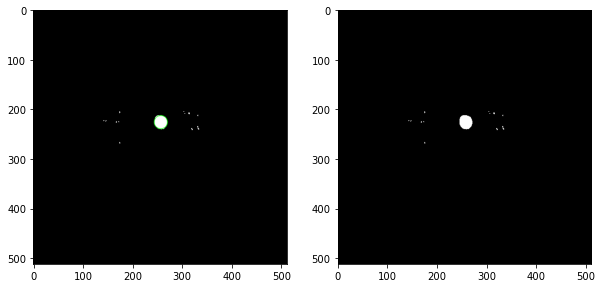

0 255
Slice 150
(< cv2.KeyPoint 0x7f3381e1f630>,)
Number of Circular Blobs: 1


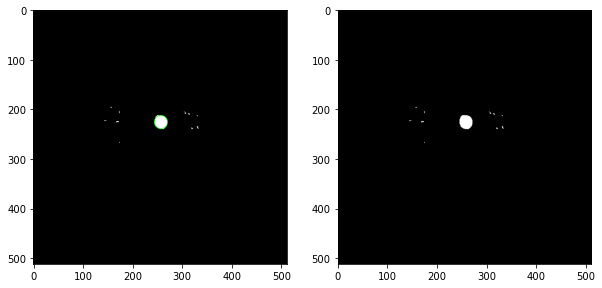

0 255
Slice 152
(< cv2.KeyPoint 0x7f334bbfb060>,)
Number of Circular Blobs: 1


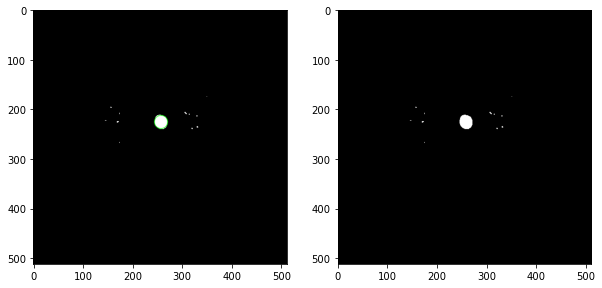

0 255
Slice 154
(< cv2.KeyPoint 0x7f334bc750c0>,)
Number of Circular Blobs: 1


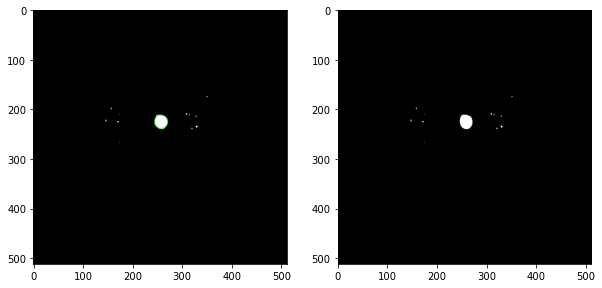

0 255
Slice 156
(< cv2.KeyPoint 0x7f334b941780>,)
Number of Circular Blobs: 1


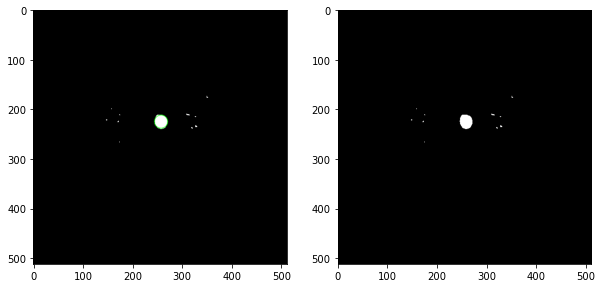

0 255
Slice 158
(< cv2.KeyPoint 0x7f334afcacc0>,)
Number of Circular Blobs: 1


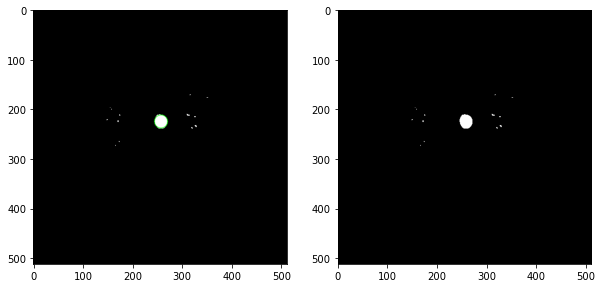

0 255
Slice 160
(< cv2.KeyPoint 0x7f334b9e4330>,)
Number of Circular Blobs: 1


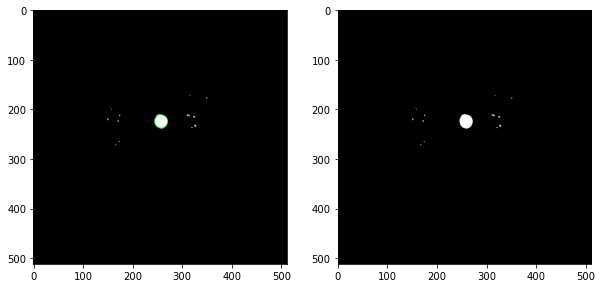

0 255
Slice 162
(< cv2.KeyPoint 0x7f3420fa2630>,)
Number of Circular Blobs: 1


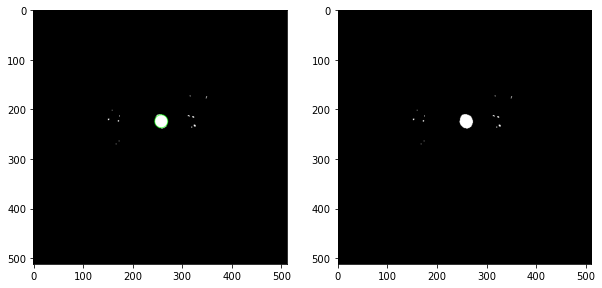

0 255
Slice 164
(< cv2.KeyPoint 0x7f3420edaea0>,)
Number of Circular Blobs: 1


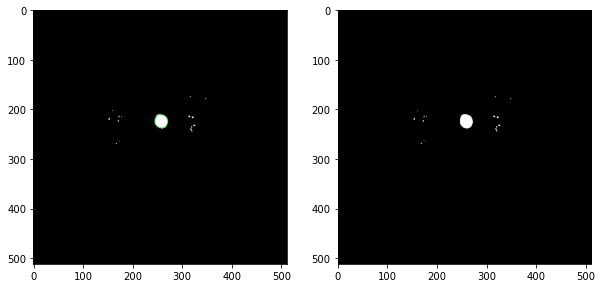

0 255
Slice 166
(< cv2.KeyPoint 0x7f334aefd240>,)
Number of Circular Blobs: 1


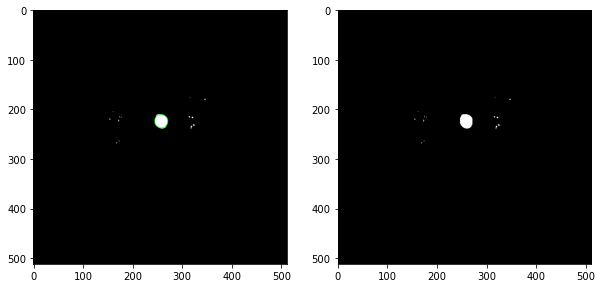

0 255
Slice 168
(< cv2.KeyPoint 0x7f334aeb89f0>,)
Number of Circular Blobs: 1


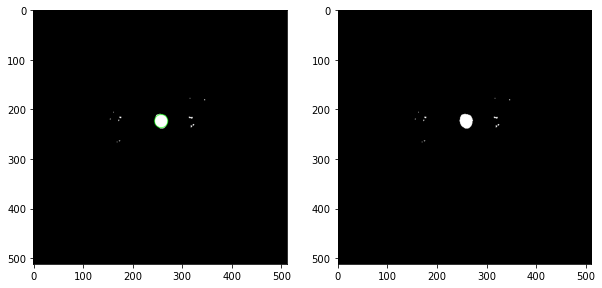

0 255
Slice 170
(< cv2.KeyPoint 0x7f334b018180>,)
Number of Circular Blobs: 1


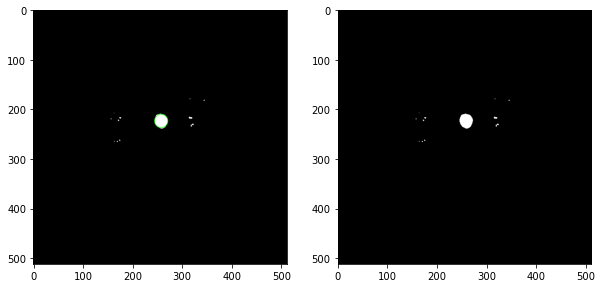

0 255
Slice 172
(< cv2.KeyPoint 0x7f334b0a2990>,)
Number of Circular Blobs: 1


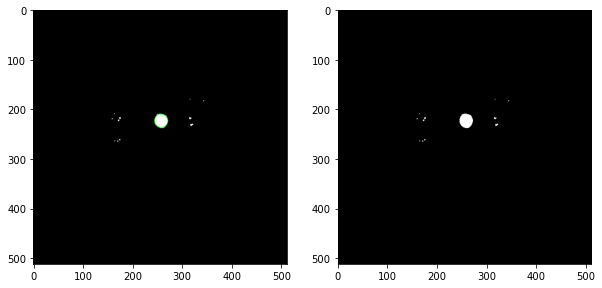

0 255
Slice 174
(< cv2.KeyPoint 0x7f334ae0dd80>,)
Number of Circular Blobs: 1


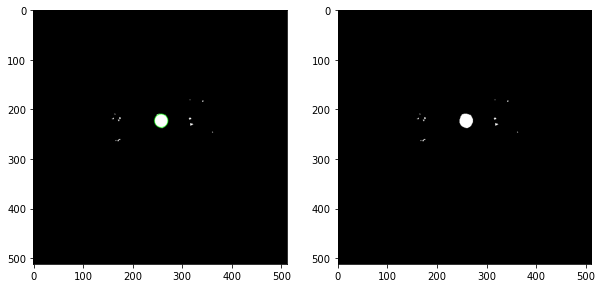

0 255
Slice 176
(< cv2.KeyPoint 0x7f334bb22960>,)
Number of Circular Blobs: 1


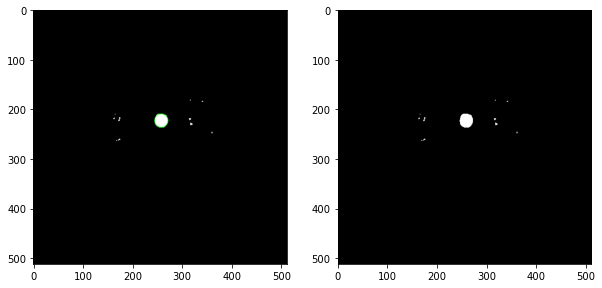

0 255
Slice 178
(< cv2.KeyPoint 0x7f334b43fdb0>,)
Number of Circular Blobs: 1


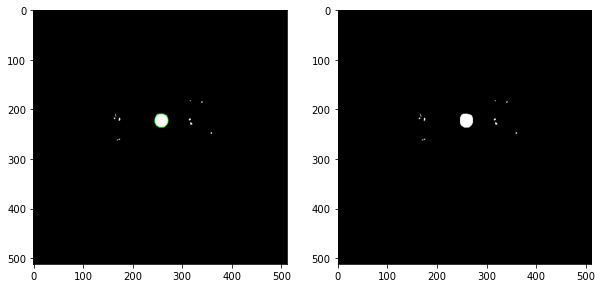

0 255
Slice 180
(< cv2.KeyPoint 0x7f334b93fc00>,)
Number of Circular Blobs: 1


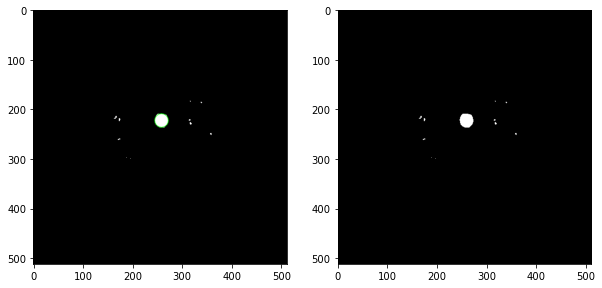

0 255
Slice 182
(< cv2.KeyPoint 0x7f334b766150>,)
Number of Circular Blobs: 1


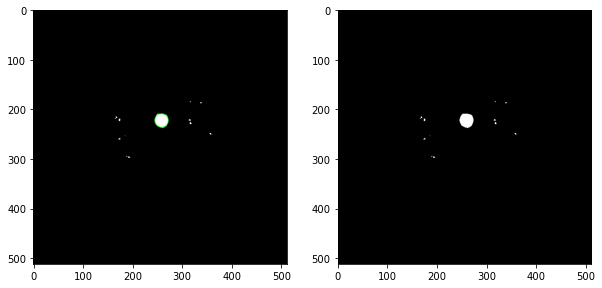

0 255
Slice 184
(< cv2.KeyPoint 0x7f334af40600>,)
Number of Circular Blobs: 1


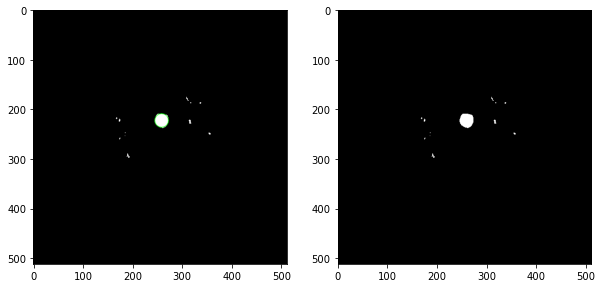

0 255
Slice 186
(< cv2.KeyPoint 0x7f334b485060>,)
Number of Circular Blobs: 1


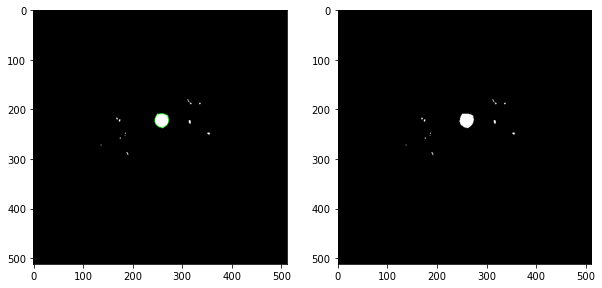

0 255
Slice 188
(< cv2.KeyPoint 0x7f334b9256c0>,)
Number of Circular Blobs: 1


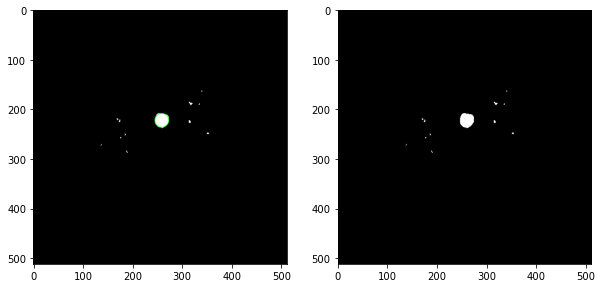

0 255
Slice 190
(< cv2.KeyPoint 0x7f334b9584e0>,)
Number of Circular Blobs: 1


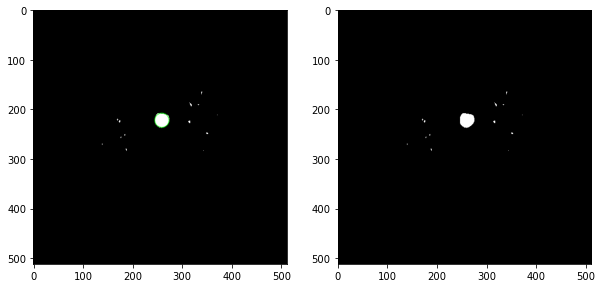

0 255
Slice 192
(< cv2.KeyPoint 0x7f33801cd690>,)
Number of Circular Blobs: 1


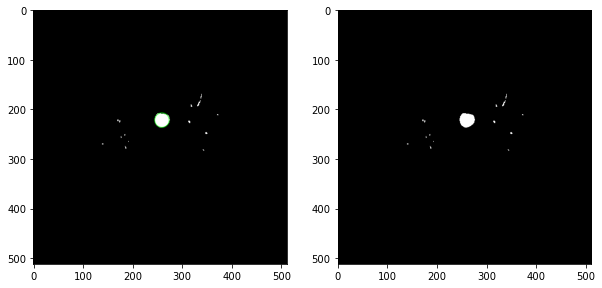

0 255
Slice 194
(< cv2.KeyPoint 0x7f338011bc90>,)
Number of Circular Blobs: 1


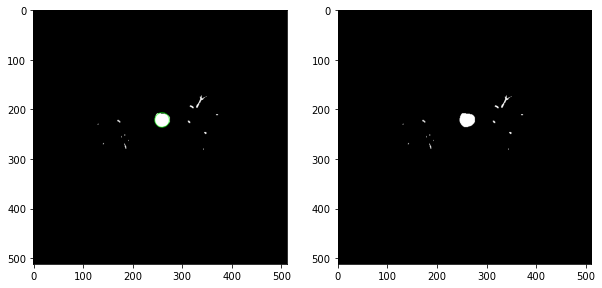

0 255
Slice 196
(< cv2.KeyPoint 0x7f334bedd6c0>,)
Number of Circular Blobs: 1


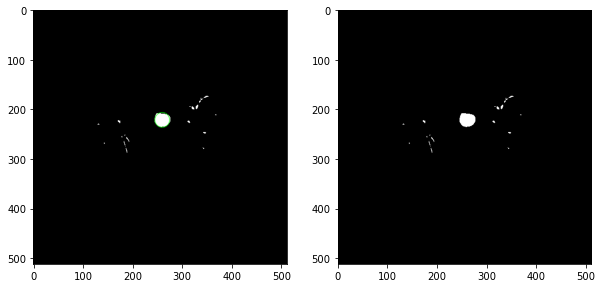

0 255
Slice 198
(< cv2.KeyPoint 0x7f3382118570>,)
Number of Circular Blobs: 1


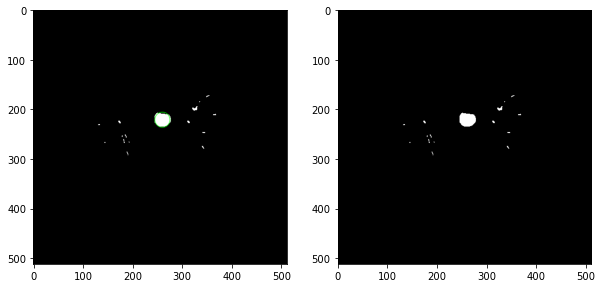

0 255
Slice 200
(< cv2.KeyPoint 0x7f33806793f0>,)
Number of Circular Blobs: 1


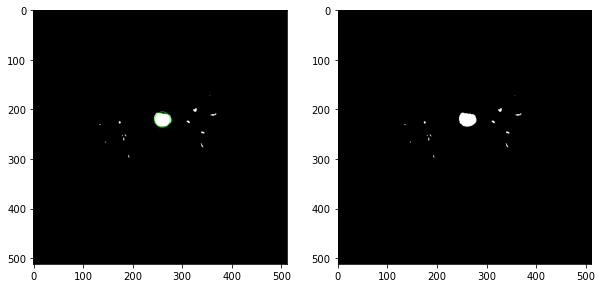

0 255
Slice 202
(< cv2.KeyPoint 0x7f334bdd2f60>,)
Number of Circular Blobs: 1


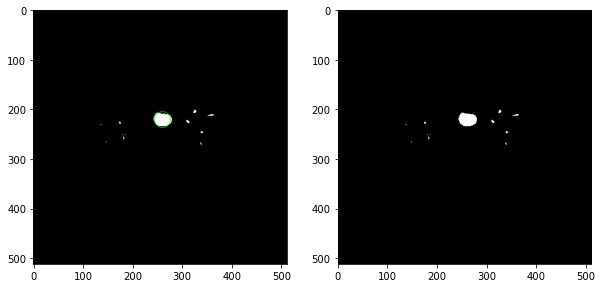

0 255
Slice 204
(< cv2.KeyPoint 0x7f33806ae030>,)
Number of Circular Blobs: 1


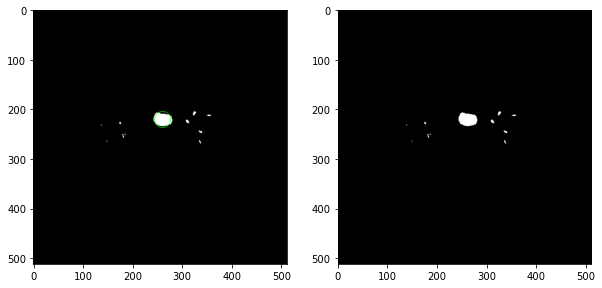

0 255
Slice 206
(< cv2.KeyPoint 0x7f334be05030>,)
Number of Circular Blobs: 1


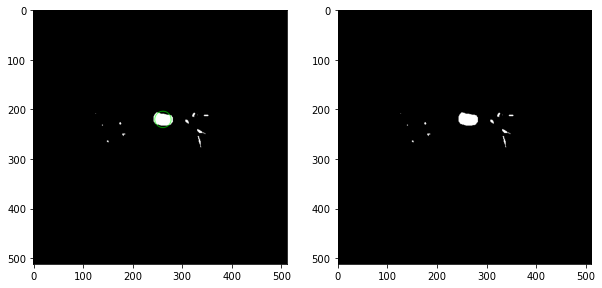

0 255
Slice 208
(< cv2.KeyPoint 0x7f338217c2d0>,)
Number of Circular Blobs: 1


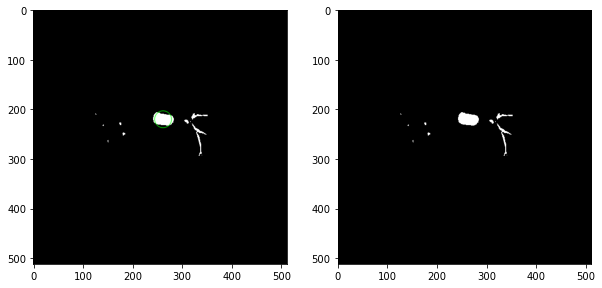

0 255
Slice 210
()
Number of Circular Blobs: 0


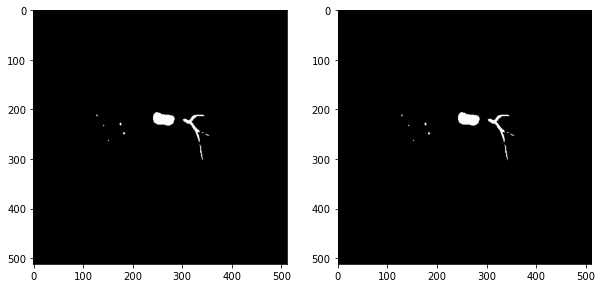

0 255
Slice 212
()
Number of Circular Blobs: 0


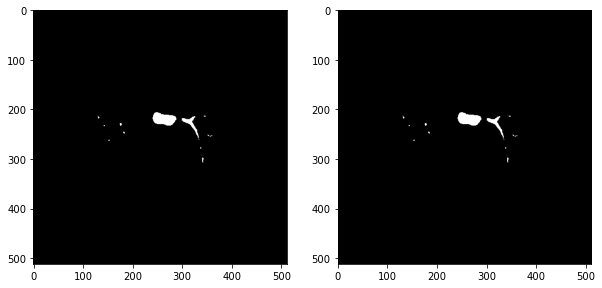

0 255
Slice 214
()
Number of Circular Blobs: 0


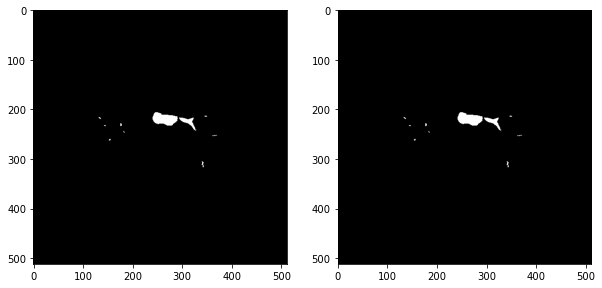

0 255
Slice 216
()
Number of Circular Blobs: 0


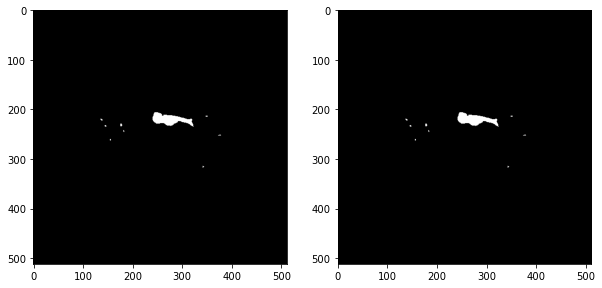

0 255
Slice 218
()
Number of Circular Blobs: 0


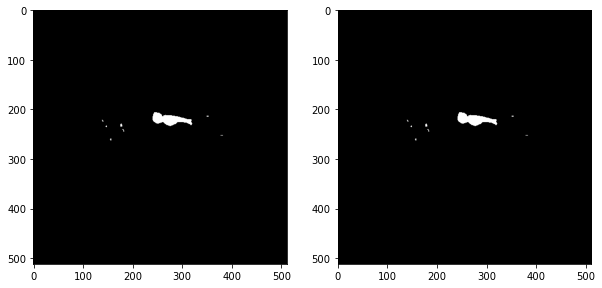

0 255
Slice 220
()
Number of Circular Blobs: 0


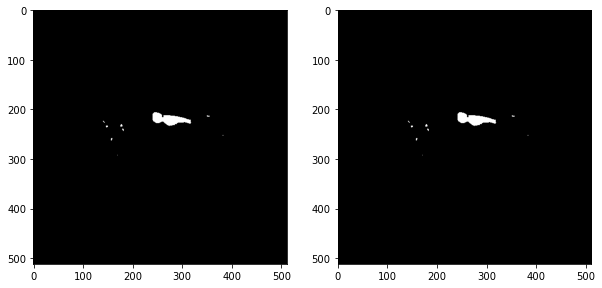

0 255
Slice 222
()
Number of Circular Blobs: 0


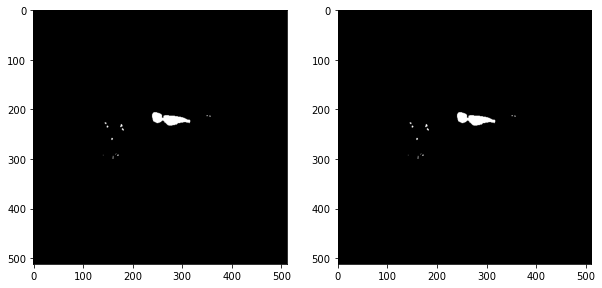

0 255
Slice 224
(< cv2.KeyPoint 0x7f334b11e870>,)
Number of Circular Blobs: 1


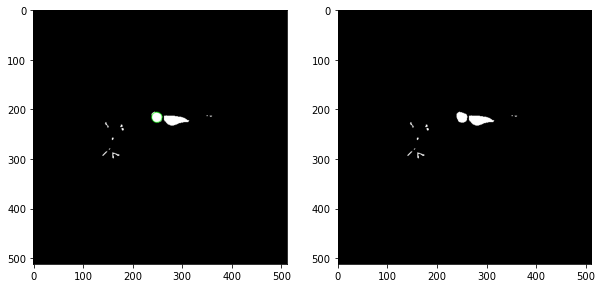

0 255
Slice 226
(< cv2.KeyPoint 0x7f3420e688d0>,)
Number of Circular Blobs: 1


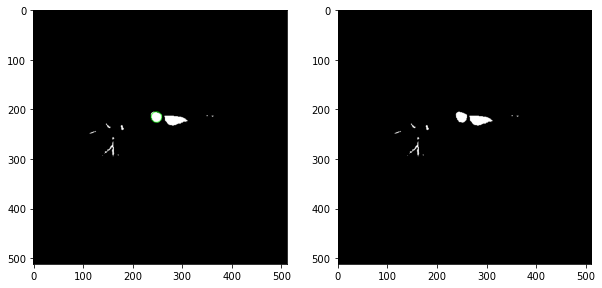

0 255
Slice 228
(< cv2.KeyPoint 0x7f334bb3b210>,)
Number of Circular Blobs: 1


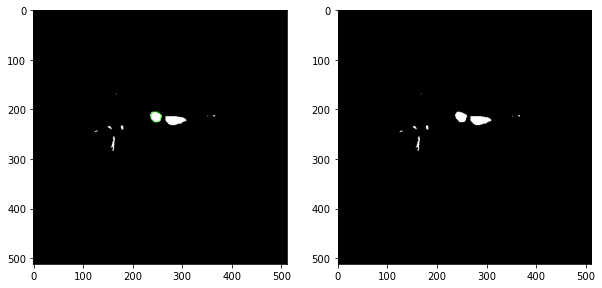

0 255
Slice 230
(< cv2.KeyPoint 0x7f334b695f00>,)
Number of Circular Blobs: 1


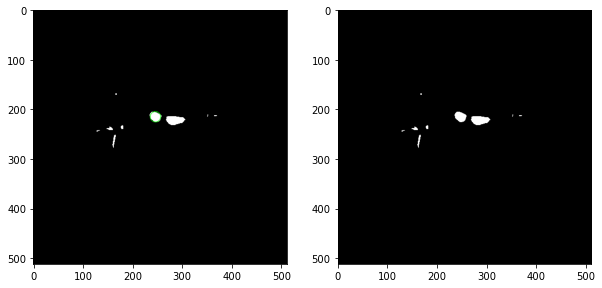

0 255
Slice 232
(< cv2.KeyPoint 0x7f334b153d80>,)
Number of Circular Blobs: 1


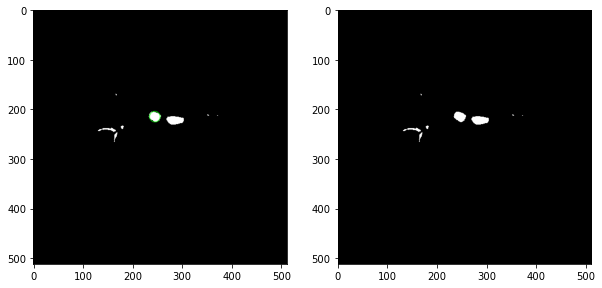

0 255
Slice 234
(< cv2.KeyPoint 0x7f334b5b99c0>,)
Number of Circular Blobs: 1


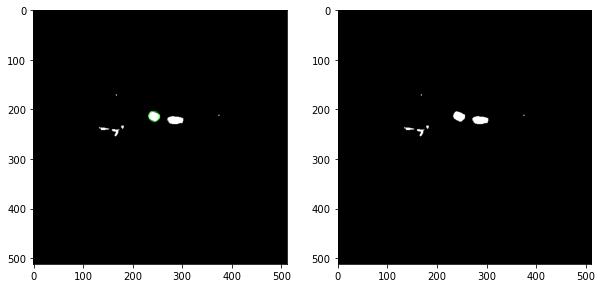

0 255
Slice 236
(< cv2.KeyPoint 0x7f334b7a1fc0>,)
Number of Circular Blobs: 1


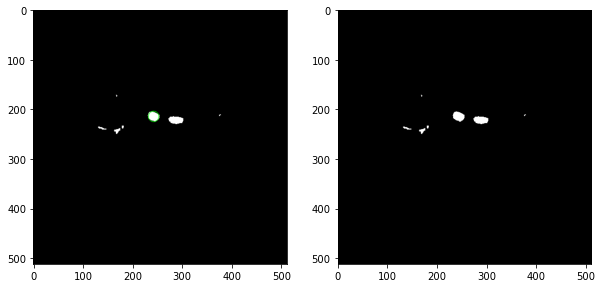

0 255
Slice 238
(< cv2.KeyPoint 0x7f3420d94f00>, < cv2.KeyPoint 0x7f3420d94db0>)
Number of Circular Blobs: 2


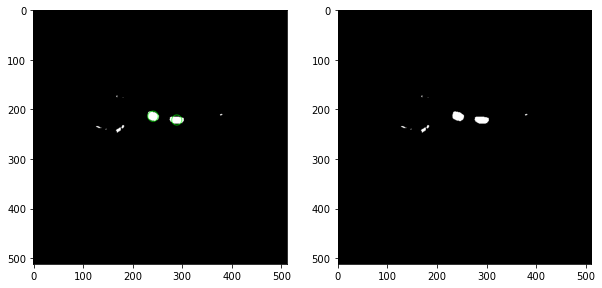

0 255
Slice 240
(< cv2.KeyPoint 0x7f3420d81ab0>, < cv2.KeyPoint 0x7f334af09fc0>)
Number of Circular Blobs: 2


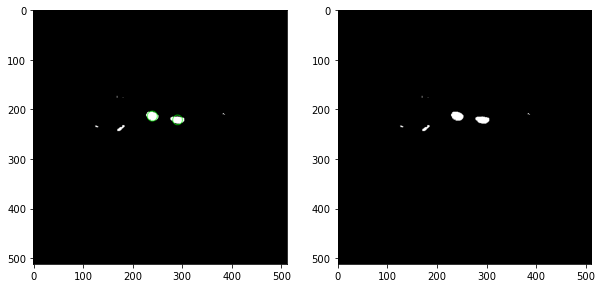

0 255
Slice 242
(< cv2.KeyPoint 0x7f334ba37630>, < cv2.KeyPoint 0x7f334ba37600>)
Number of Circular Blobs: 2


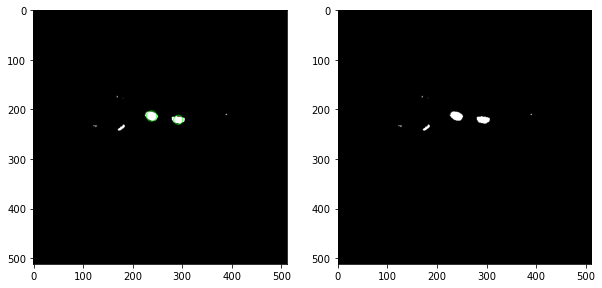

0 255
Slice 244
(< cv2.KeyPoint 0x7f334b186cf0>, < cv2.KeyPoint 0x7f334b186cc0>)
Number of Circular Blobs: 2


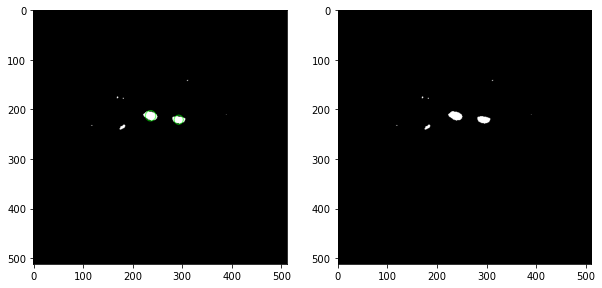

0 255
Slice 246
(< cv2.KeyPoint 0x7f334b55a2a0>,)
Number of Circular Blobs: 1


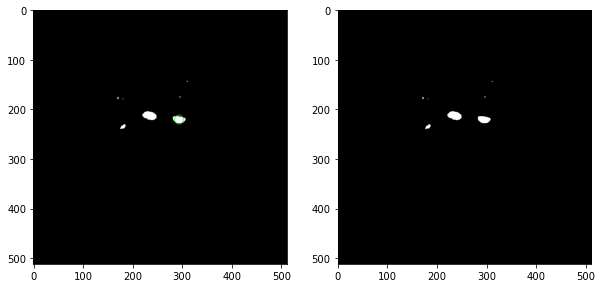

0 255
Slice 248
(< cv2.KeyPoint 0x7f334bee89c0>, < cv2.KeyPoint 0x7f334bee8cc0>)
Number of Circular Blobs: 2


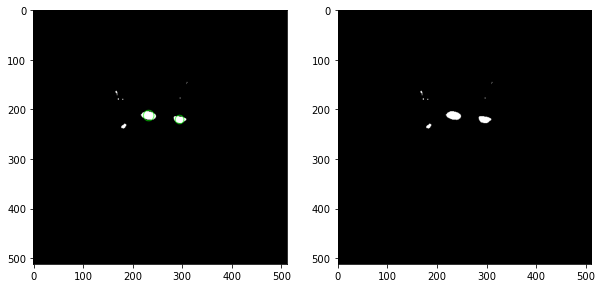

0 255
Slice 250
(< cv2.KeyPoint 0x7f334ba2a750>, < cv2.KeyPoint 0x7f334ba2a6f0>)
Number of Circular Blobs: 2


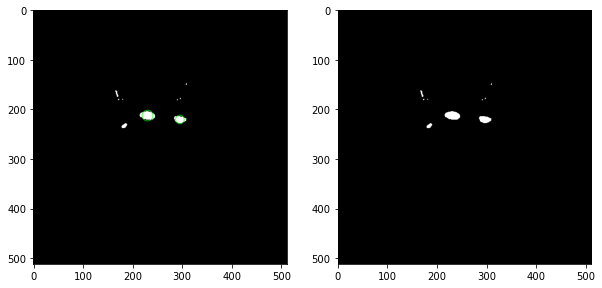

0 255
Slice 252
(< cv2.KeyPoint 0x7f33825e9060>, < cv2.KeyPoint 0x7f338160a2d0>)
Number of Circular Blobs: 2


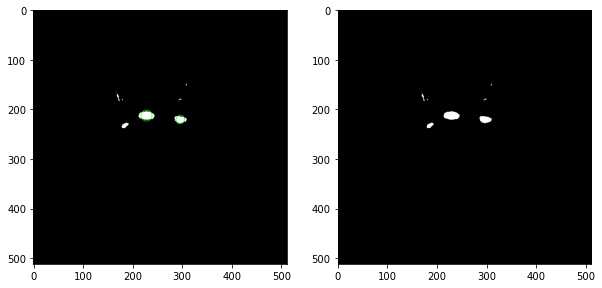

0 255
Slice 254
(< cv2.KeyPoint 0x7f334bd13b40>,)
Number of Circular Blobs: 1


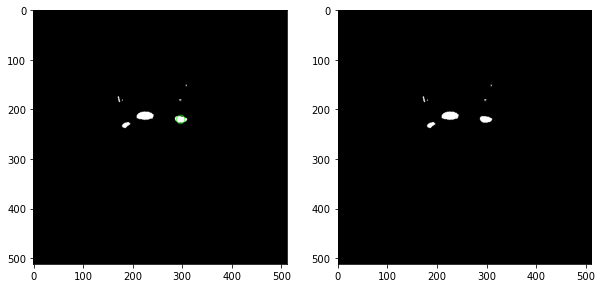

0 255
Slice 256
(< cv2.KeyPoint 0x7f338076c690>,)
Number of Circular Blobs: 1


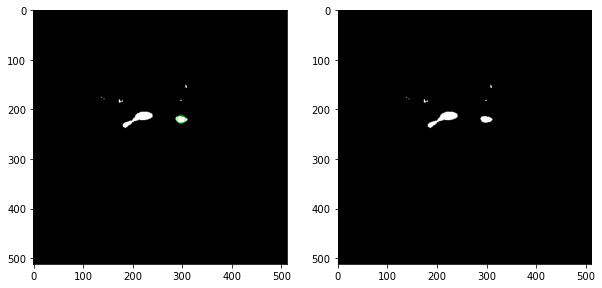

0 255
Slice 258
(< cv2.KeyPoint 0x7f3420de4a50>,)
Number of Circular Blobs: 1


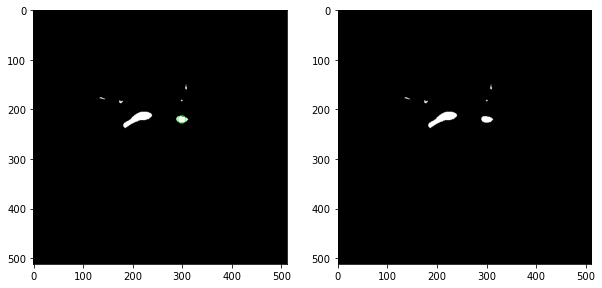

0 255
Slice 260
(< cv2.KeyPoint 0x7f334b6e8e10>,)
Number of Circular Blobs: 1


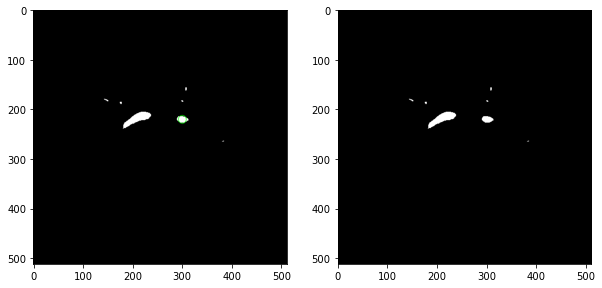

0 255
Slice 262
(< cv2.KeyPoint 0x7f334bd70030>,)
Number of Circular Blobs: 1


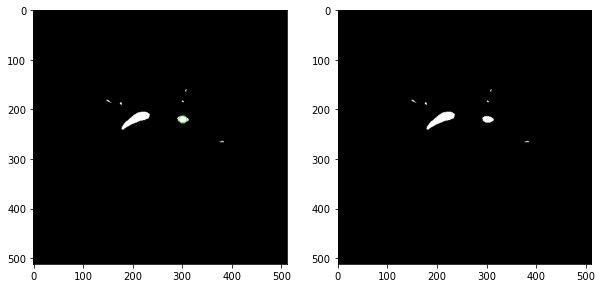

0 255
Slice 264
(< cv2.KeyPoint 0x7f334bd1a3c0>,)
Number of Circular Blobs: 1


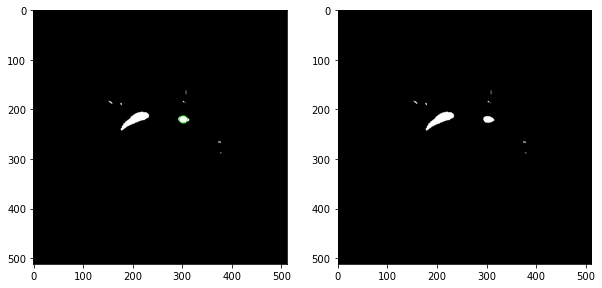

0 255
Slice 266
(< cv2.KeyPoint 0x7f334bfa5600>,)
Number of Circular Blobs: 1


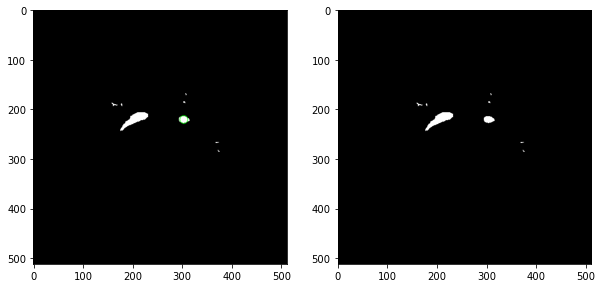

0 255
Slice 268
(< cv2.KeyPoint 0x7f334bb9aba0>,)
Number of Circular Blobs: 1


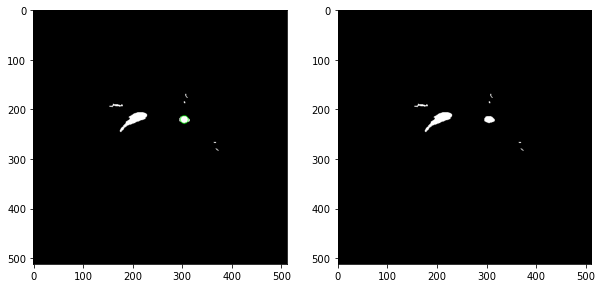

0 255
Slice 270
(< cv2.KeyPoint 0x7f334bceb840>,)
Number of Circular Blobs: 1


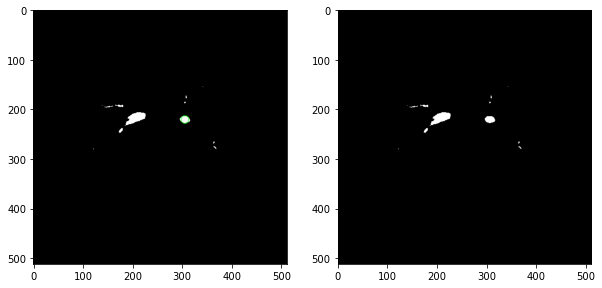

0 255
Slice 272
(< cv2.KeyPoint 0x7f334b96c870>,)
Number of Circular Blobs: 1


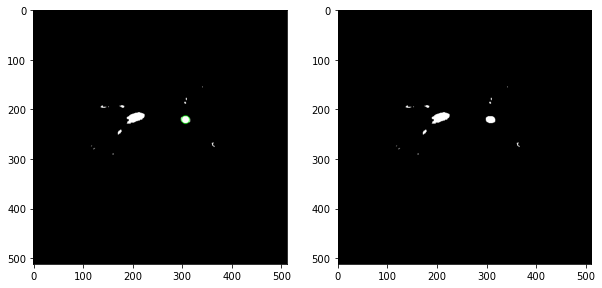

0 255
Slice 274
(< cv2.KeyPoint 0x7f334b7b3db0>,)
Number of Circular Blobs: 1


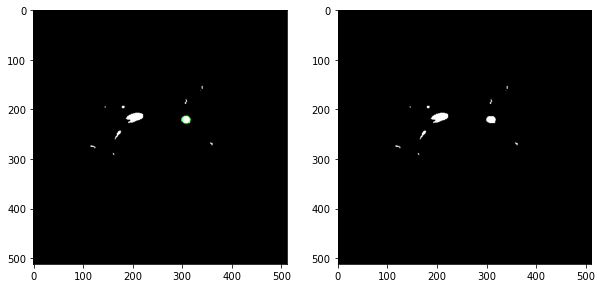

0 255
Slice 276
(< cv2.KeyPoint 0x7f334b6f1240>,)
Number of Circular Blobs: 1


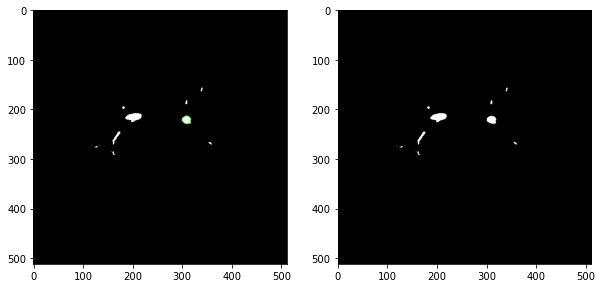

0 255
Slice 278
(< cv2.KeyPoint 0x7f334b79c360>,)
Number of Circular Blobs: 1


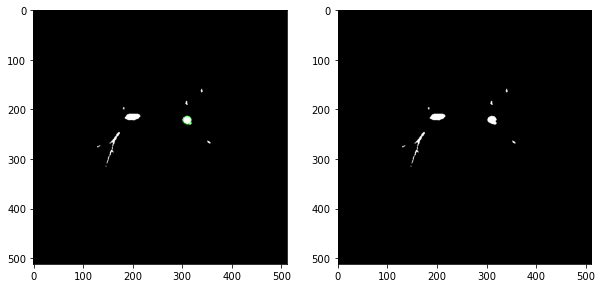

0 255
Slice 280
(< cv2.KeyPoint 0x7f334b067060>,)
Number of Circular Blobs: 1


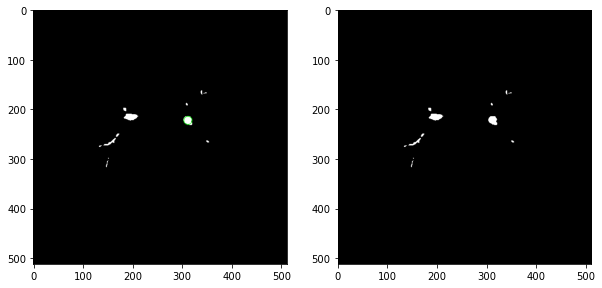

0 255
Slice 282
()
Number of Circular Blobs: 0


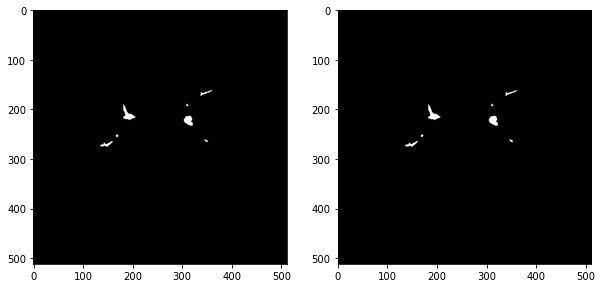

0 255
Slice 284
()
Number of Circular Blobs: 0


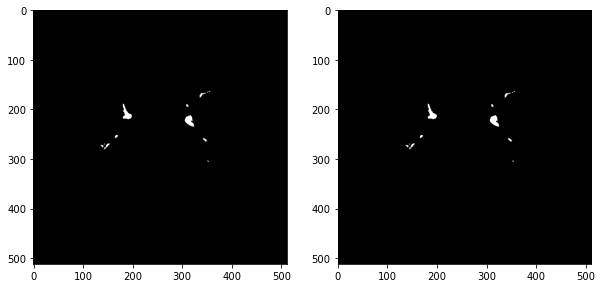

0 255
Slice 286
()
Number of Circular Blobs: 0


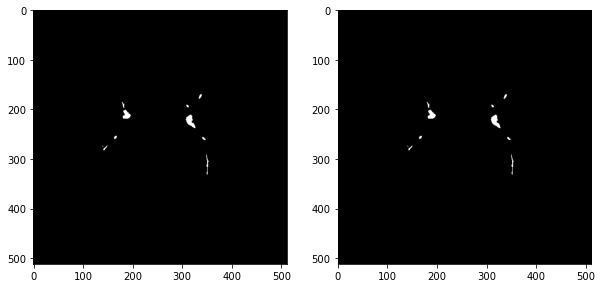

0 255
Slice 288
()
Number of Circular Blobs: 0


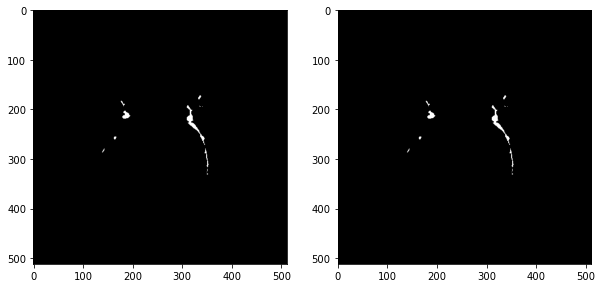

0 255
Slice 290
()
Number of Circular Blobs: 0


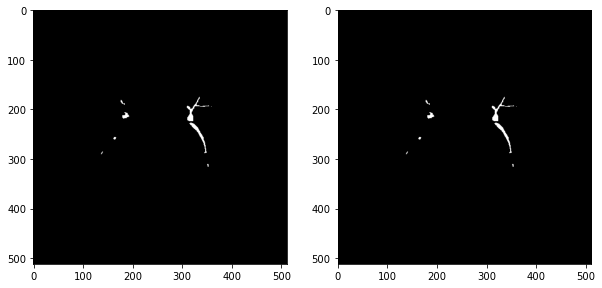

0 255
Slice 292
()
Number of Circular Blobs: 0


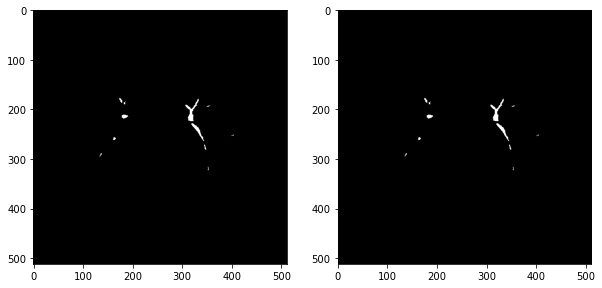

0 255
Slice 294
()
Number of Circular Blobs: 0


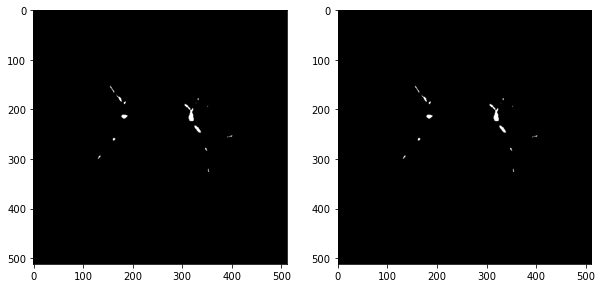

0 255
Slice 296
()
Number of Circular Blobs: 0


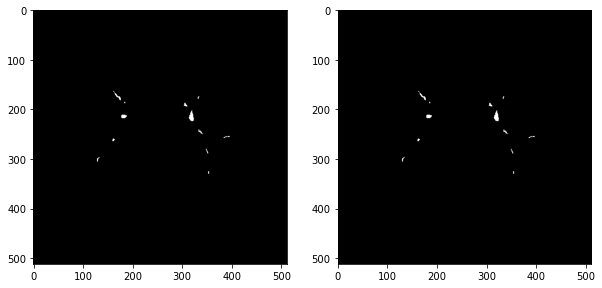

0 255
Slice 298
()
Number of Circular Blobs: 0


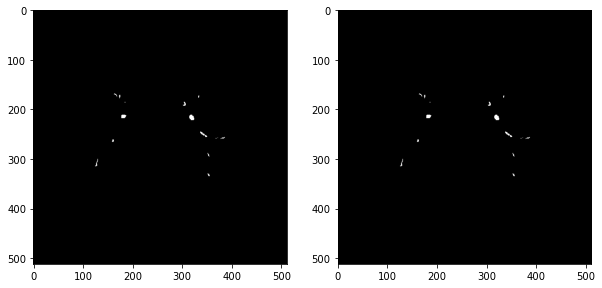

0 255
Slice 300
()
Number of Circular Blobs: 0


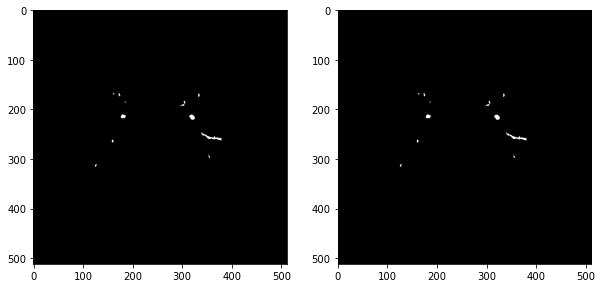

0 255
Slice 302
()
Number of Circular Blobs: 0


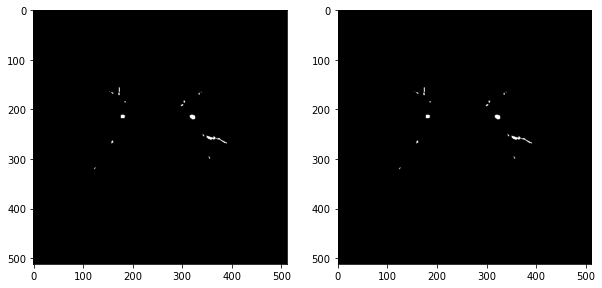

0 255
Slice 304
()
Number of Circular Blobs: 0


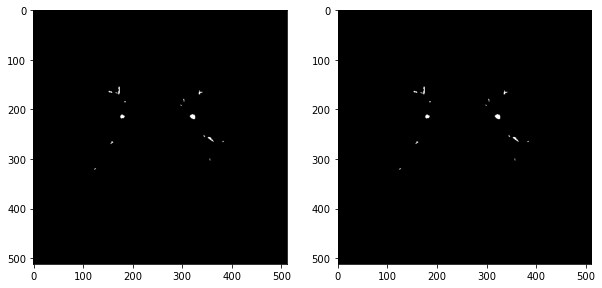

0 255
Slice 306
()
Number of Circular Blobs: 0


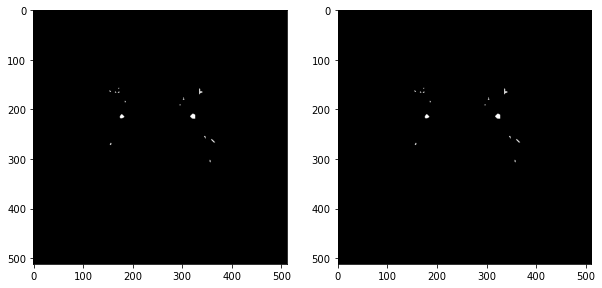

0 255
Slice 308
()
Number of Circular Blobs: 0


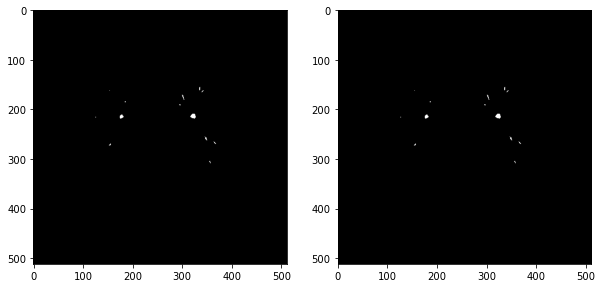

0 255
Slice 310
()
Number of Circular Blobs: 0


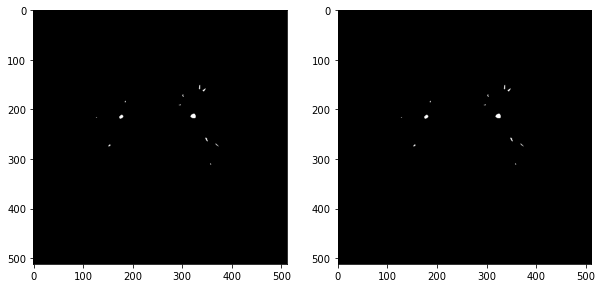

0 255
Slice 312
()
Number of Circular Blobs: 0


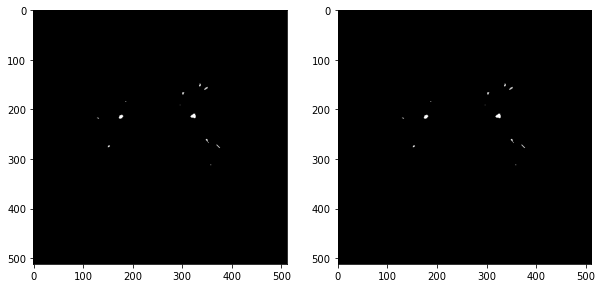

0 255
Slice 314
()
Number of Circular Blobs: 0


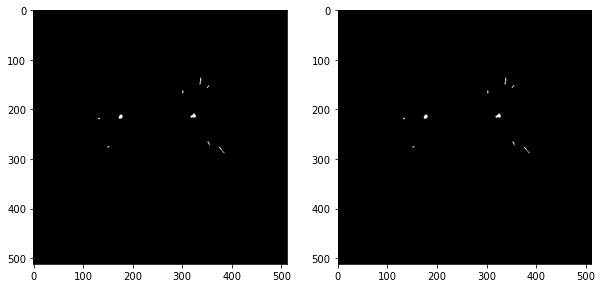

0 255
Slice 316
()
Number of Circular Blobs: 0


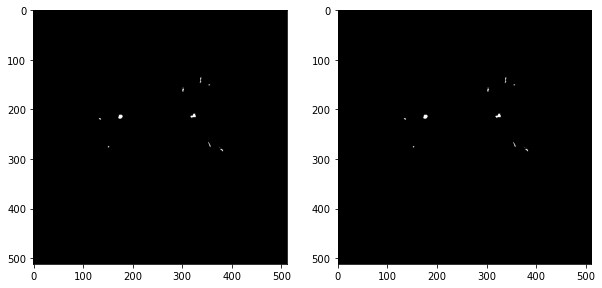

0 255
Slice 318
()
Number of Circular Blobs: 0


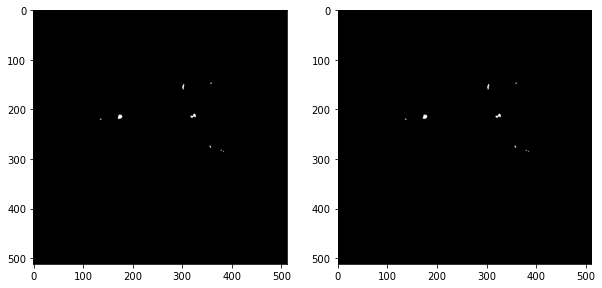

0 255
Slice 320
()
Number of Circular Blobs: 0


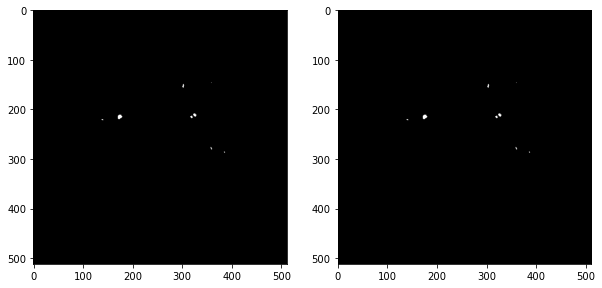

0 255
Slice 322
()
Number of Circular Blobs: 0


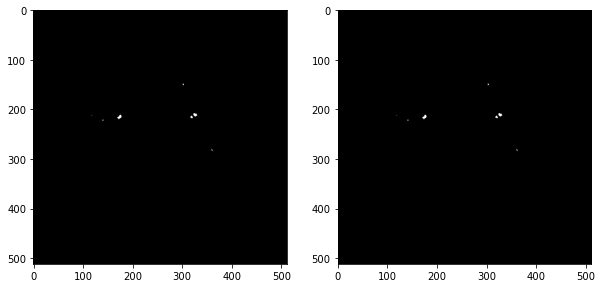

0 255
Slice 324
()
Number of Circular Blobs: 0


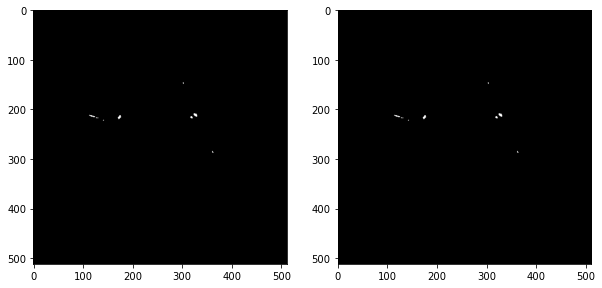

0 255
Slice 326
()
Number of Circular Blobs: 0


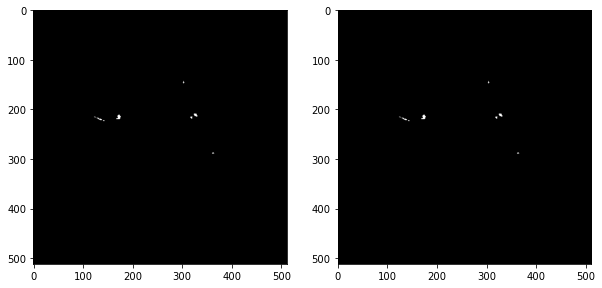

0 255
Slice 328
()
Number of Circular Blobs: 0


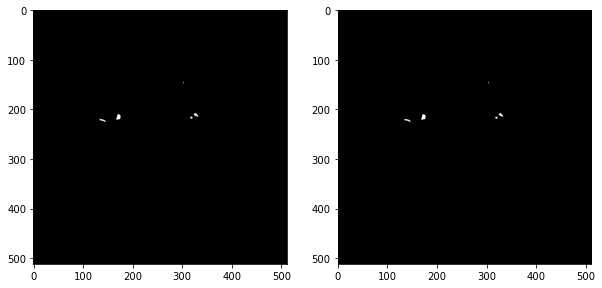

0 255
Slice 330
()
Number of Circular Blobs: 0


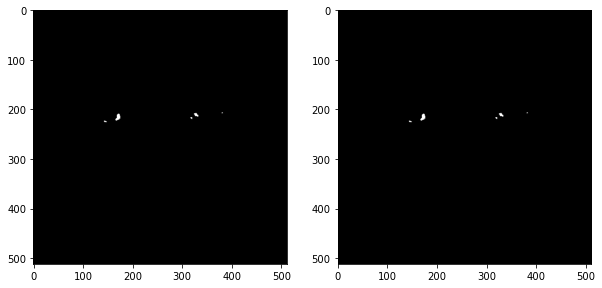

0 255
Slice 332
()
Number of Circular Blobs: 0


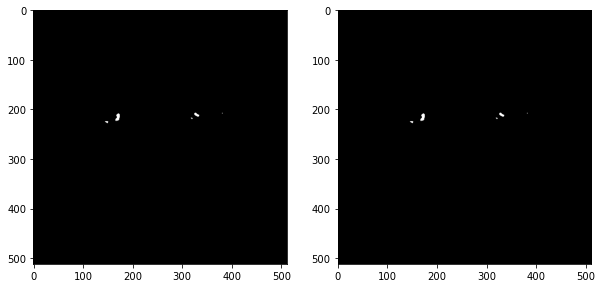

0 255
Slice 334
()
Number of Circular Blobs: 0


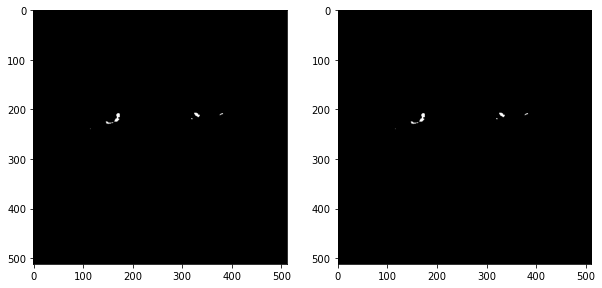

0 255
Slice 336
()
Number of Circular Blobs: 0


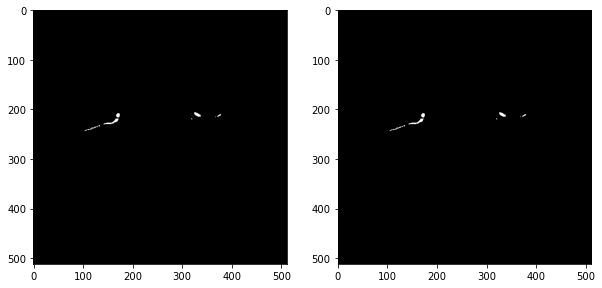

0 255
Slice 338
()
Number of Circular Blobs: 0


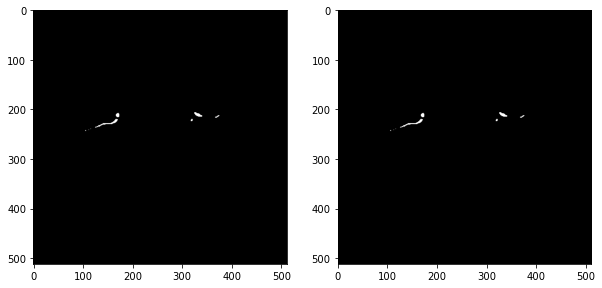

0 255
Slice 340
()
Number of Circular Blobs: 0


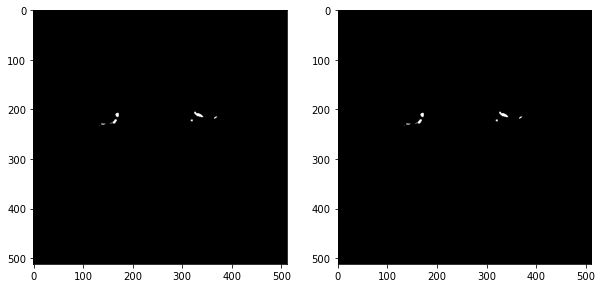

0 255
Slice 342
()
Number of Circular Blobs: 0


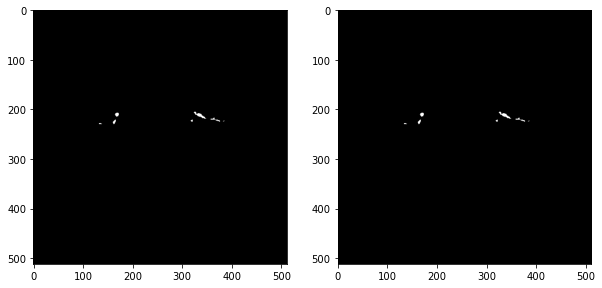

0 255
Slice 344
()
Number of Circular Blobs: 0


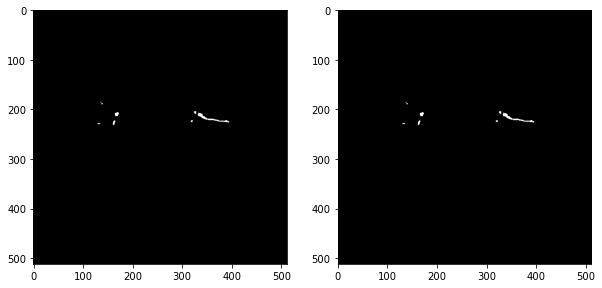

0 255
Slice 346
()
Number of Circular Blobs: 0


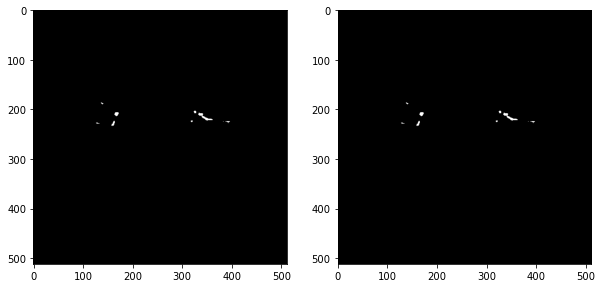

0 255
Slice 348
()
Number of Circular Blobs: 0


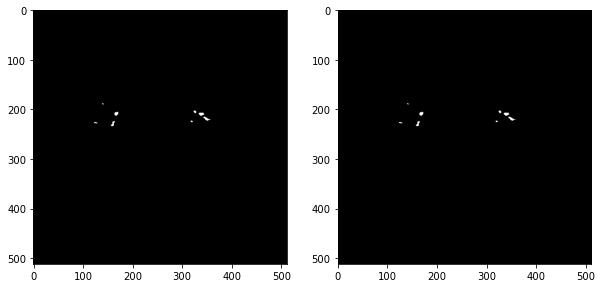

In [137]:
aw_array =  sitk.GetArrayFromImage(aw_img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
# slice 223 find carina
for i in range(50,350, 2):
    _slice = cv2.cvtColor( aw_array[i,:,:], cv2.COLOR_GRAY2RGB)
    cv2img = aw_array[i,:,:]
#     cv2img[np.where(cv2img == 255)] = 1
    print(cv2img.min(), cv2img.max())
    im_gauss = cv2img #cv2.GaussianBlur(cv2img, (1, 1), 0)
    
    #np.zeros_like(_slice)
#     opening = cv2.morphologyEx(cv2img, cv2.MORPH_OPEN, kernel, iterations=3)
    print(f"Slice {i}")
    params = cv2.SimpleBlobDetector_Params()
 
    # Set Area filtering parameters
    params.filterByArea = True
    params.minArea = 100

    # Set Circularity filtering parameters
    params.filterByCircularity = True
    params.minCircularity = 0.7

    # Set Convexity filtering parameters
    params.filterByConvexity = True
    params.minConvexity = 0.2

    # Set inertia filtering parameters
    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    
    # blobl colour
    params.blobColor = 255

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs
    keypoints = detector.detect(im_gauss)
    print(keypoints)
    # Draw blobs on our image as red circles
    blank = np.zeros((1, 1))
    blobs = cv2.drawKeypoints(_slice , keypoints, blank, (0, 255, 0),
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    number_of_blobs = len(keypoints)
    text = "Number of Circular Blobs: " + str(len(keypoints))
    print(text)
    cv2.putText(blobs, text, (20, 550),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show blobs
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(blobs)
    ax2.imshow(im_gauss, cmap='gray')
#     plt.show()
#     plt.imshow(cv2img)
    plt.show()
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
#     # Find contours and filter using contour area and aspect ratio
#     cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     print(len(cnts), cnts)
#     display_image(aw_img,256,256, i)
    
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.04 * peri, True)
#     area = cv2.contourArea(c)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     for c in cnts:
#         if len(approx) > 5 and area > 1000 and area < 500000:
#             ((x, y), r) = cv2.minEnclosingCircle(c)
#             cv2.circle(cv2img, (int(x), int(y)), int(r), (36, 255, 12), 2)
# #                     cv2.circle(cv2img, center, radius, (255, 0, 0), -1)
#             plt.imshow(cv2img)

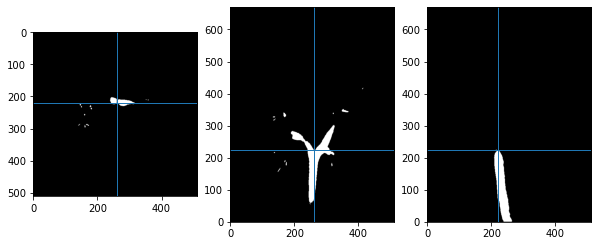

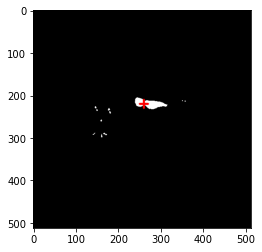

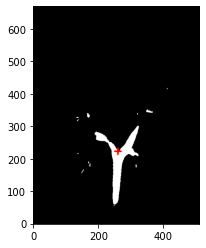

In [187]:
_slice = cv2.cvtColor( aw_array[223,:,:], cv2.COLOR_GRAY2RGB)
display_image(aw_img, 260,220,223)


# CARINA

cv2.drawMarker(_slice, (260,220), (255,0,0),cv2.MARKER_CROSS,20,4)
plt.imshow(_slice)
plt.show()

_slice_2 = cv2.cvtColor(aw_array[:,220,:], cv2.COLOR_GRAY2RGB)
cv2.drawMarker(_slice_2, (260,223), (255,0,0),cv2.MARKER_CROSS,20,4)
plt.imshow(_slice_2, origin='lower')

In [ ]:
aw_array =  sitk.GetArrayFromImage(aw_img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(aw_array, cv2.MORPH_OPEN, kernel, iterations=3)

# Find contours and filter using contour area and aspect ratio
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
plt.hist(img_array.flatten(), bins=20, density=False)

In [ ]:
plt.figure(figsize=(20,20))
interactive_view(label_overlay(aw_img, aw_img))
# poisson shape mapping --> normalised + radial distance --> this is somewhere on file - pdcm
# VIDA lobelevel